# French Renewable Energy Data Pre-Processing

### Generation Data

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.constants import convert_temperature
import plotly.express as px

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout
from math import sqrt

from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [2]:
France_Renewable = pd.read_csv("../../Data/Generation/Europe_Renewables.csv",
                   usecols=(lambda s: s.startswith('utc') | s.startswith('FR')),
                    parse_dates=[0], index_col=0)    

In [3]:
France_Renewable.head()

FR_load_actual_entsoe_power_statistics  \
utc_timestamp                                                       
2004-12-31 23:00:00+00:00                                     NaN   
2005-01-01 00:00:00+00:00                                     NaN   
2005-01-01 01:00:00+00:00                                     NaN   
2005-01-01 02:00:00+00:00                                     NaN   
2005-01-01 03:00:00+00:00                                     NaN   

                           FR_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2004-12-31 23:00:00+00:00                                 NaN   
2005-01-01 00:00:00+00:00                                 NaN   
2005-01-01 01:00:00+00:00                                 NaN   
2005-01-01 02:00:00+00:00                                 NaN   
2005-01-01 03:00:00+00:00                                 NaN   

                           FR_load_actual_tso  \
utc_timestamp                                   
2004-12-31 23:00:00+00:00                 NaN   
2005-01-01 00:00:00+00:00                 NaN   
2005-01-01 01:00:00+00:00                 NaN   
2005-01-01 02:00:00+00:00                 NaN   
2005-01-01 03:00:00+00:00                 NaN   

                           FR_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2004-12-31 23:00:00+00:00                                   NaN   
2005-01-01 00:00:00+00:00                                   NaN   
2005-01-01 01:00:00+00:00                                   NaN   
2005-01-01 02:00:00+00:00                                   NaN   
2005-01-01 03:00:00+00:00                                   NaN   

                           FR_load_forecast_tso  FR_solar_generation_actual  \
utc_timestamp                                                                 
2004-12-31 23:00:00+00:00                   NaN                         NaN   
2005-01-01 00:00:00+00:00                   NaN                         NaN   
2005-01-01 01:00:00+00:00                   NaN                         NaN   
2005-01-01 02:00:00+00:00                   NaN                         NaN   
2005-01-01 03:00:00+00:00                   NaN                         NaN   

                           FR_wind_onshore_generation_actual  
utc_timestamp                                                 
2004-12-31 23:00:00+00:00                                NaN  
2005-01-01 00:00:00+00:00                                NaN  
2005-01-01 01:00:00+00:00                                NaN  
2005-01-01 02:00:00+00:00                                NaN  
2005-01-01 03:00:00+00:00                                NaN

In [4]:
def clean_renewable_data(data):

    data['Index'] = data.reset_index(inplace=True)
    data['Index'] = range(1, len(data) + 1)
    data = France_Renewable[['utc_timestamp', 'FR_solar_generation_actual', 'FR_wind_onshore_generation_actual']]
    data = data.rename(columns={"FR_solar_generation_actual": "Solar KwH"})
    data = data.rename(columns={"FR_wind_onshore_generation_actual": "Wind KwH"})
    data = data.rename(columns={"utc_timestamp": "Date"})
    data['Total'] = data['Solar KwH'] + data['Wind KwH']
    data = data.round(2)
    data = data.fillna(0)

    return data 

France_Renewable = clean_renewable_data(France_Renewable)

In [5]:
France_Renewable.head()

Date  Solar KwH  Wind KwH  Total
0 2004-12-31 23:00:00+00:00        0.0       0.0    0.0
1 2005-01-01 00:00:00+00:00        0.0       0.0    0.0
2 2005-01-01 01:00:00+00:00        0.0       0.0    0.0
3 2005-01-01 02:00:00+00:00        0.0       0.0    0.0
4 2005-01-01 03:00:00+00:00        0.0       0.0    0.0

In [6]:
def date_limits(data):

    data['Date'] = data['Date'].astype('datetime64[ns]')
    start_date = '01-01-2016'
    end_date = '12-31-2016'
    mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
    data = data.loc[mask]
    data.reset_index(inplace=True)
    
    return data

France_Renewable = date_limits(France_Renewable)    
France_Renewable.head()

index                Date  Solar KwH  Wind KwH   Total
0  96409 2016-01-01 00:00:00       -1.0    2082.0  2081.0
1  96410 2016-01-01 01:00:00       -1.0    1690.0  1689.0
2  96411 2016-01-01 02:00:00       -1.0    1414.0  1413.0
3  96412 2016-01-01 03:00:00       -1.0    1200.0  1199.0
4  96413 2016-01-01 04:00:00       -1.0    1000.0   999.0

### Weather Data

In [7]:
France_weather = pd.read_csv("../../Data/Generation/FranceWeather.csv", low_memory = False)

In [8]:
France_weather.head()

# Date UT time  Temperature  Relative Humidity  Pressure  Wind speed  \
0  2016-01-01   01:00       282.79              83.61   1005.81        2.13   
1  2016-01-01   02:00       282.57              83.98   1005.48        2.24   
2  2016-01-01   03:00       282.30              84.26   1005.28        2.35   
3  2016-01-01   04:00       281.98              84.72   1005.16        2.46   
4  2016-01-01   05:00       281.70              85.30   1005.12        2.69   

   Wind direction  Rainfall  Snowfall  Snow depth Short-wave irradiation  
0           89.96  0.013449       0.0         0.0                 0.0000  
1           79.76  0.005852       0.0         0.0                 0.0000  
2           69.75  0.005272       0.0         0.0                 0.0000  
3           59.75  0.008434       0.0         0.0                 0.0000  
4           55.55  0.009532       0.0         0.0                 0.0000

In [9]:
def clean_weather_data(data):
    
    data = data.rename(columns={"# Date": "Date"})
    data['Date'] = data['Date']  + ' ' + data['UT time']
    data['Date'] = data['Date'].str.replace(r'\b24:00\b', '00:00')
    data['Date'] = data['Date'].astype('datetime64[ns]')
    
    data = data.groupby(data.Date).mean()
    data.reset_index(inplace=True)

    return data 

France_weather = clean_weather_data(France_weather)

In [10]:
France_weather.head()

Date  Temperature  Relative Humidity     Pressure  \
0 2016-01-01 00:00:00   279.844167          92.480000   982.646667   
1 2016-01-01 01:00:00   282.790000          83.610000  1005.810000   
2 2016-01-01 02:00:00   278.203333          96.711667   994.886667   
3 2016-01-01 03:00:00   278.110833          96.420833   994.885833   
4 2016-01-01 04:00:00   278.080833          95.588333   994.741667   

   Wind speed  Wind direction  Rainfall  Snowfall    Snow depth  
0    5.700000      155.613333  0.453094  0.000380  3.000000e-06  
1    2.130000       89.960000  0.013449  0.000000  0.000000e+00  
2    2.305833      170.605000  0.011153  0.000019  5.833333e-07  
3    2.289167      171.334167  0.010858  0.000022  5.833333e-07  
4    2.338333      168.735000  0.013468  0.000023  6.666667e-07

In [11]:
print(len(France_weather))

8784


In [12]:
France_weather_2 = pd.read_csv("../../Data/Generation/FranceWeather2.csv",
                                parse_dates=[0], index_col=0)    

In [13]:
France_weather_2.head()

FR_windspeed_10m  FR_temperature  \
utc_timestamp                                                 
2016-01-01 00:00:00+00:00              2.86           5.571   
2016-01-01 01:00:00+00:00              2.68           5.415   
2016-01-01 02:00:00+00:00              2.51           5.288   
2016-01-01 03:00:00+00:00              2.45           5.177   
2016-01-01 04:00:00+00:00              2.35           5.131   

                           FR_radiation_direct_horizontal  \
utc_timestamp                                               
2016-01-01 00:00:00+00:00                             0.0   
2016-01-01 01:00:00+00:00                             0.0   
2016-01-01 02:00:00+00:00                             0.0   
2016-01-01 03:00:00+00:00                             0.0   
2016-01-01 04:00:00+00:00                             0.0   

                           FR_radiation_diffuse_horizontal  
utc_timestamp                                               
2016-01-01 00:00:00+00:00                              0.0  
2016-01-01 01:00:00+00:00                              0.0  
2016-01-01 02:00:00+00:00                              0.0  
2016-01-01 03:00:00+00:00                              0.0  
2016-01-01 04:00:00+00:00                              0.0

In [14]:
def clean_weather_2(data): 

    data.reset_index(inplace=True)
    data.columns = data.columns.str.replace(r'(^.*windspeed_.*$)', 'Wind Velocity (10m)')
    data.columns = data.columns.str.replace(r'(^.*direct.*$)', 'Atmospheric Horizontal Radiation')
    data.columns = data.columns.str.replace(r'(^.*diffuse.*$)', 'Atmospheric Ground Radiation')
    data = data.rename(columns={"utc_timestamp": "Date"})
    data = data.drop(['FR_temperature'], axis=1)
    
    data['Date'] = data['Date'].astype('datetime64[ns]')
    data ['Date'] = data['Date'].astype('datetime64')
    data ['Month'] = data['Date'].dt.month
    data ['Day'] = data['Date'].dt.dayofweek
    data ['Hour'] = data['Date'].dt.hour
    data.reset_index(inplace=True)
        
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    month_to_season = dict(zip(range(1,13), seasons))
    data['Season'] = data.Month.map(month_to_season)
    
    return data

France_weather_2 = clean_weather_2(France_weather_2)

In [15]:
France_weather_2.head()

index                Date  Wind Velocity (10m)  \
0      0 2016-01-01 00:00:00                 2.86   
1      1 2016-01-01 01:00:00                 2.68   
2      2 2016-01-01 02:00:00                 2.51   
3      3 2016-01-01 03:00:00                 2.45   
4      4 2016-01-01 04:00:00                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0      1    4   
1                               0.0                           0.0      1    4   
2                               0.0                           0.0      1    4   
3                               0.0                           0.0      1    4   
4                               0.0                           0.0      1    4   

   Hour  Season  
0     0       1  
1     1       1  
2     2       1  
3     3       1  
4     4       1

In [16]:
France_Renewable = France_Renewable[France_Renewable.index < 8760]
France_weather = France_weather[France_weather.index < 8760]
France_weather_2 = France_weather_2[France_weather_2.index < 8760]

In [17]:
def merge(Weather, Weather_2, Generation):
    
    Merge = pd.merge(Weather, Weather_2, on= "Date", how="left")
    Country = pd.merge(Generation, Merge , on = "Date", how = "left")
    Country = Country.dropna()
    Country = Country.drop(['index_x', 'index_y'], axis=1)
    Country = Country.round(2)
    
    return Country

France = merge(France_weather, France_weather_2, France_Renewable)

In [18]:
France.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0 2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1 2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2 2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3 2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4 2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

In [19]:
France.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8760
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              8760 non-null   datetime64[ns]
 1   Solar KwH                         8760 non-null   float64       
 2   Wind KwH                          8760 non-null   float64       
 3   Total                             8760 non-null   float64       
 4   Temperature                       8760 non-null   float64       
 5   Relative Humidity                 8760 non-null   float64       
 6   Pressure                          8760 non-null   float64       
 7   Wind speed                        8760 non-null   float64       
 8   Wind direction                    8760 non-null   float64       
 9   Rainfall                          8760 non-null   float64       
 10  Snowfall                          8760 non-null 

In [20]:
France.describe().round(2)

Solar KwH  Wind KwH     Total  Temperature  Relative Humidity  \
count    8760.00   8760.00   8760.00      8760.00            8760.00   
mean      941.91   2386.47   3328.38       284.82              78.77   
std      1325.88   1792.78   2049.24         7.03              14.46   
min        -2.00     53.00    108.00       270.77              37.16   
25%        -1.00   1065.75   1639.75       279.30              68.34   
50%        27.00   1846.00   2942.00       283.88              83.54   
75%      1772.00   3214.50   4675.50       290.03              90.79   
max      5213.00   8620.00  10833.00       305.22             100.60   

       Pressure  Wind speed  Wind direction  Rainfall  Snowfall  Snow depth  \
count   8760.00     8760.00         8760.00   8760.00   8760.00     8760.00   
mean     987.78        3.81          198.62      0.11      0.00        0.00   
std        7.97        1.40           63.69      0.18      0.02        0.00   
min      960.14        1.11           37.55      0.00      0.00        0.00   
25%      983.12        2.79          144.94      0.01      0.00        0.00   
50%      988.45        3.46          202.00      0.04      0.00        0.00   
75%      992.79        4.52          251.46      0.14      0.00        0.00   
max     1009.91       11.01          332.94      1.79      0.37        0.02   

       Wind Velocity (10m)  Atmospheric Horizontal Radiation  \
count              8760.00                           8760.00   
mean                  4.05                             90.21   
std                   1.53                            165.10   
min                   1.36                              0.00   
25%                   2.96                              0.00   
50%                   3.67                              0.74   
75%                   4.84                            100.07   
max                  12.15                            838.32   

       Atmospheric Ground Radiation    Month     Day     Hour   Season  
count                       8760.00  8760.00  8760.0  8760.00  8760.00  
mean                          72.05     6.50     3.0    11.50     2.50  
std                           93.97     3.44     2.0     6.92     1.11  
min                            0.00     1.00     0.0     0.00     1.00  
25%                            0.00     4.00     1.0     5.75     2.00  
50%                            8.40     7.00     3.0    11.50     3.00  
75%                          131.81     9.00     5.0    17.25     3.00  
max                          398.21    12.00     6.0    23.00     4.00

In [21]:
France.to_csv(r'../../Processed_Data/France_Renewable_Processed.csv', index = False)

In [22]:
France.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0 2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1 2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2 2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3 2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4 2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

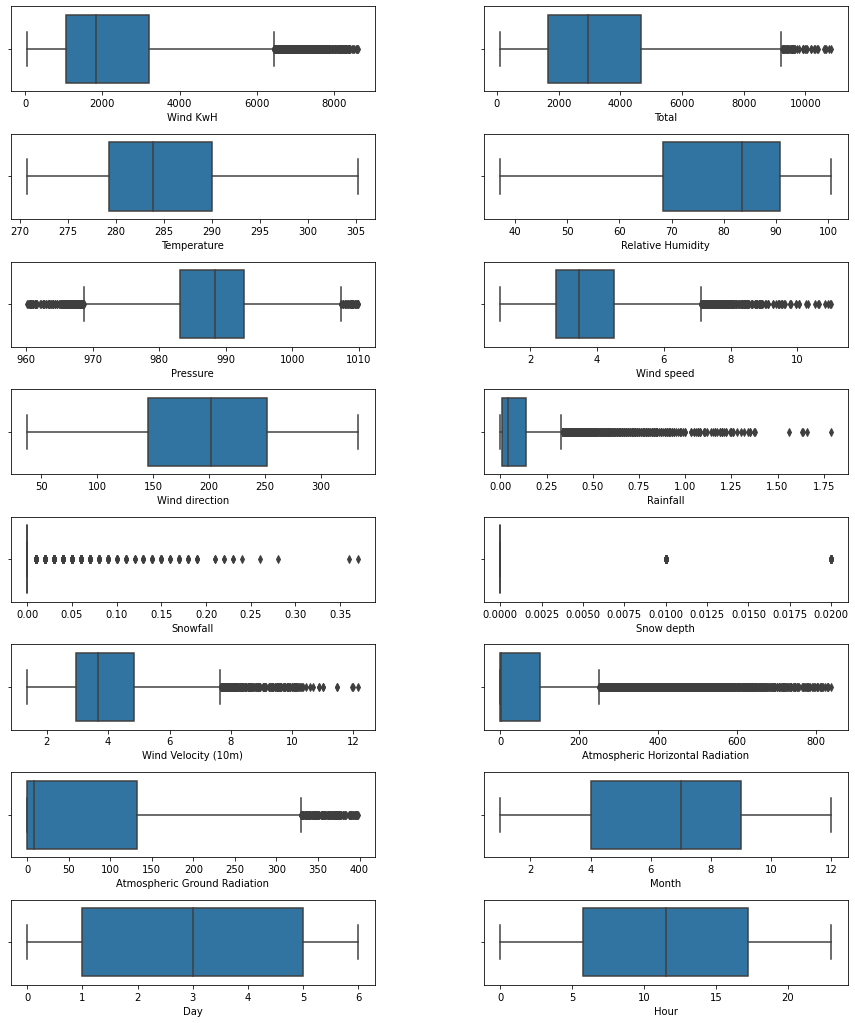

In [23]:
fig, axes = plt.subplots(ncols = 2, nrows = 8, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), France.columns[2:]):
    sns.boxplot(x = France[col], ax = ax)

In [24]:
def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
  
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Date', fontsize=16)
    
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if label:
        ax.legend(fontsize=16)
        
    if title:
        ax.set_title(title, fontsize=24)
        
    ax.grid(True)
    return ax

/Users/chris/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


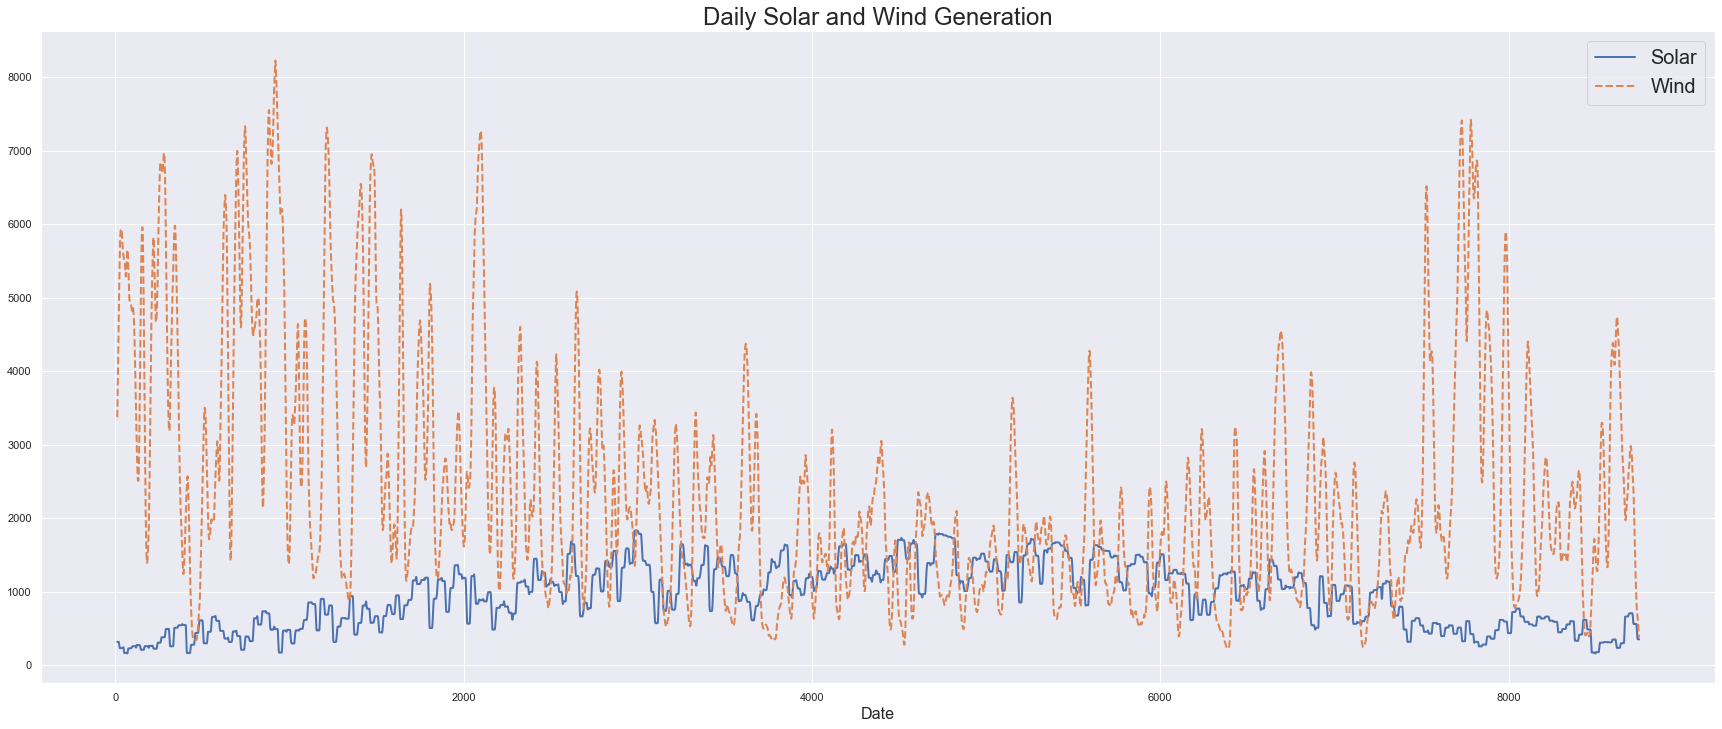

In [25]:
import datetime

Solar_daily = France['Solar KwH'].rolling(24, center= True).mean()
Wind_daily = France['Wind KwH'].rolling(24, center= True).mean()

ax = plot_series(title='Daily Solar and Wind Generation')

ax.plot(Solar_daily, linestyle='-', linewidth=2, label='Solar')
ax.plot(Wind_daily, linestyle='--', linewidth=2, label='Wind')
ax.legend(prop={'size': 20})

plt.show()

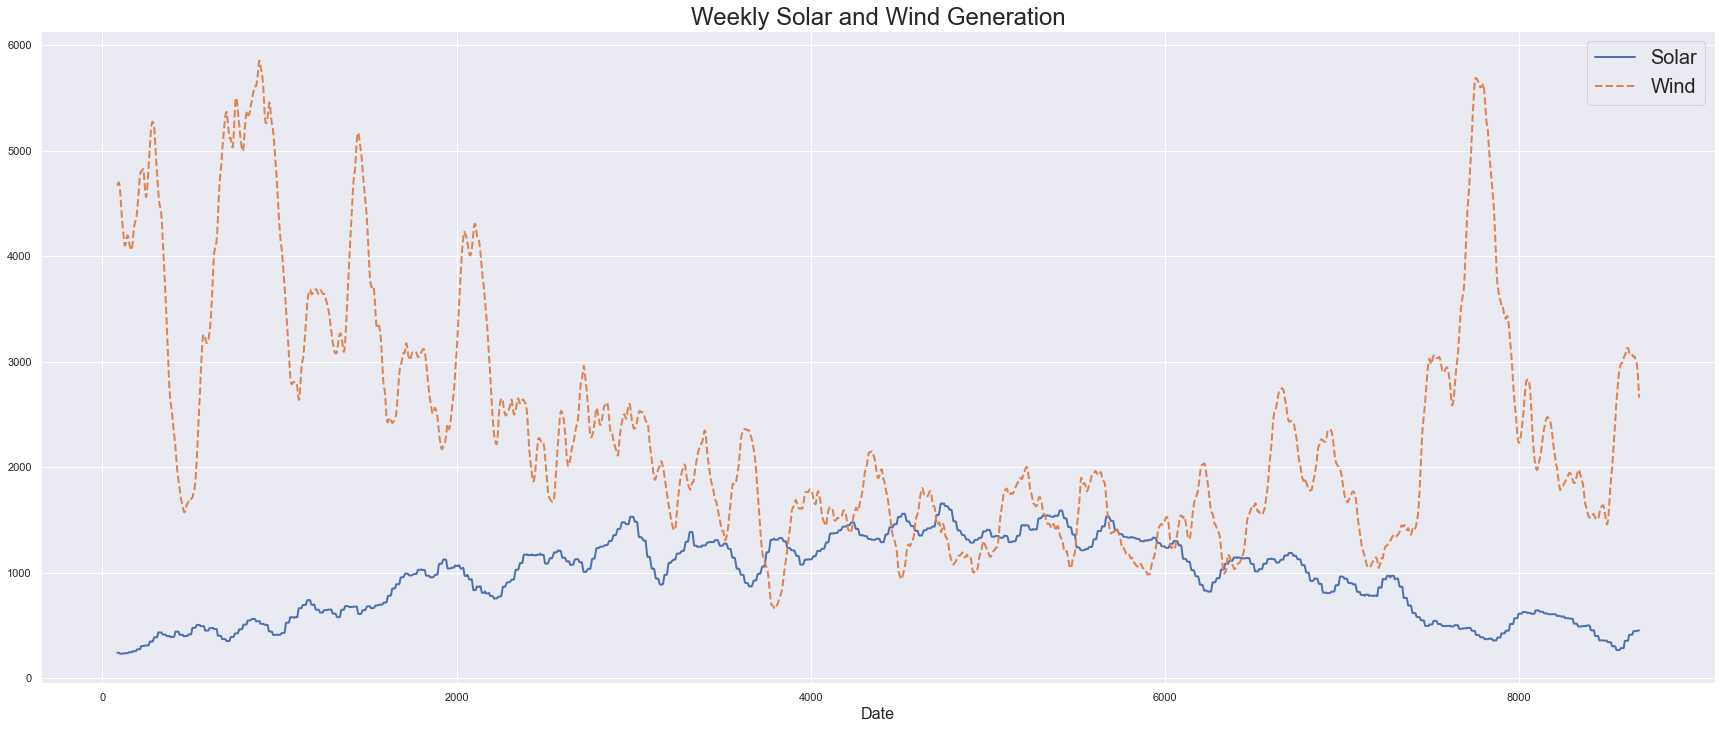

In [26]:
Solar_weekly = France['Solar KwH'].rolling(24*7, center= True).mean()
Wind_weekly = France['Wind KwH'].rolling(24*7, center= True).mean()

ax = plot_series(title='Weekly Solar and Wind Generation')

ax.plot(Solar_weekly, linestyle='-', linewidth=2, label='Solar')
ax.plot(Wind_weekly, linestyle='--', linewidth=2, label='Wind')
ax.legend(prop={'size': 20})

plt.show()

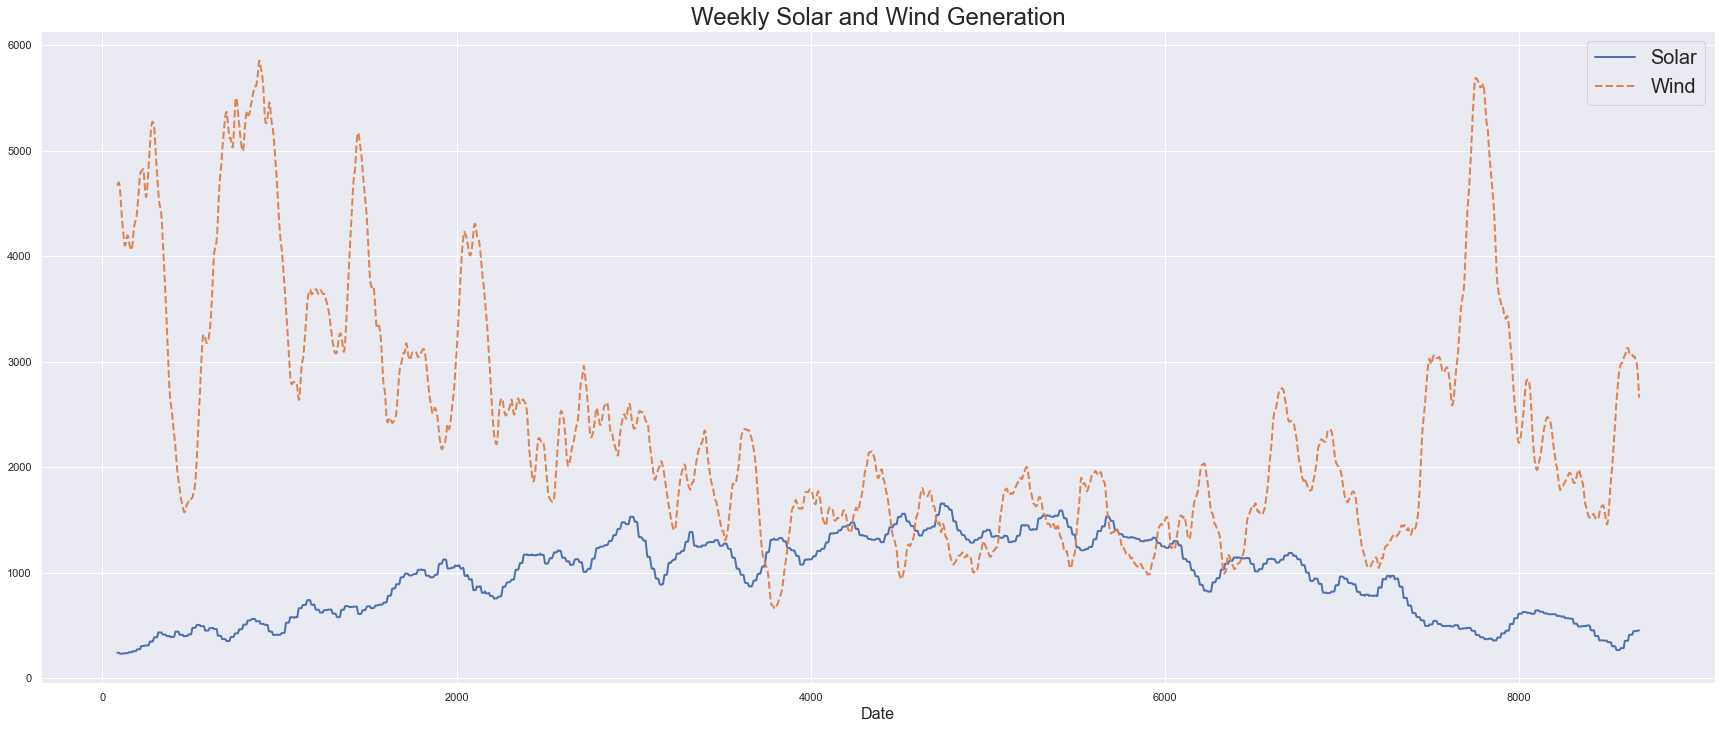

In [27]:
Solar_monthly = France['Solar KwH'].rolling(24*30, center= True).mean()
Wind_monthly = France['Wind KwH'].rolling(24*30, center= True).mean()

ax = plot_series(title='Weekly Solar and Wind Generation')

ax.plot(Solar_weekly, linestyle='-', linewidth=2, label='Solar')
ax.plot(Wind_weekly, linestyle='--', linewidth=2, label='Wind')
ax.legend(prop={'size': 20})

plt.show()

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(France['Solar KwH'], lags=50, ax=ax1)
plot_pacf(France['Solar KwH'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(France['Wind KwH'], lags=50, ax=ax1)
plot_pacf(France['Wind KwH'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

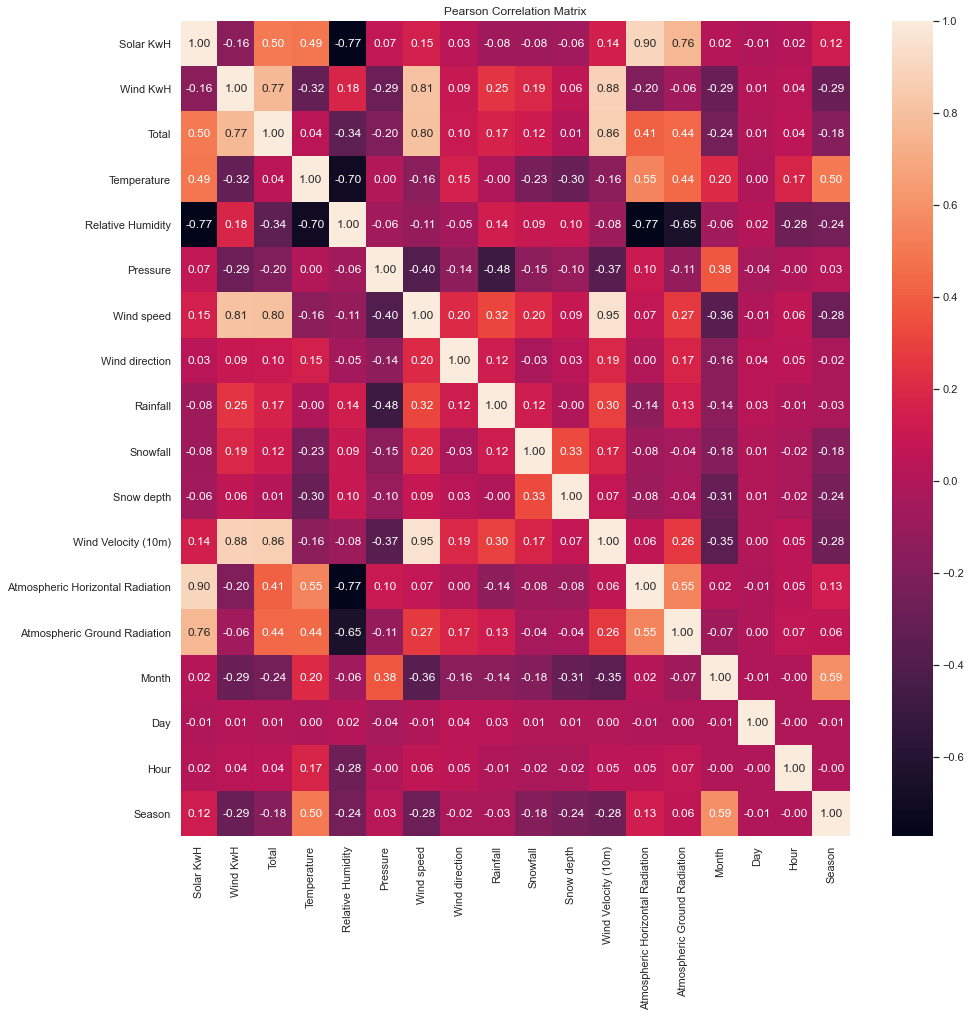

In [30]:
correlations = France.corr(method='pearson')
fig = plt.figure(figsize=(15, 15))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [31]:
Solar_Wind_Ratio = (France['Solar KwH'].sum() / (France['Total'].sum())).round(2)
print(Solar_Wind_Ratio)

0.28


In [32]:
renewable_agg = France.groupby(['Month'], as_index=False, sort=False)['Total'].sum()
solar_agg = France.groupby(['Month'], as_index=False, sort=False)['Solar KwH'].sum()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Wind KwH', x = renewable_agg['Month'], y= renewable_agg['Total']),
    go.Bar(name='Solar KwH', x = solar_agg['Month'], y= solar_agg['Solar KwH'])
])

fig.update_layout(barmode='stack')
fig.show()

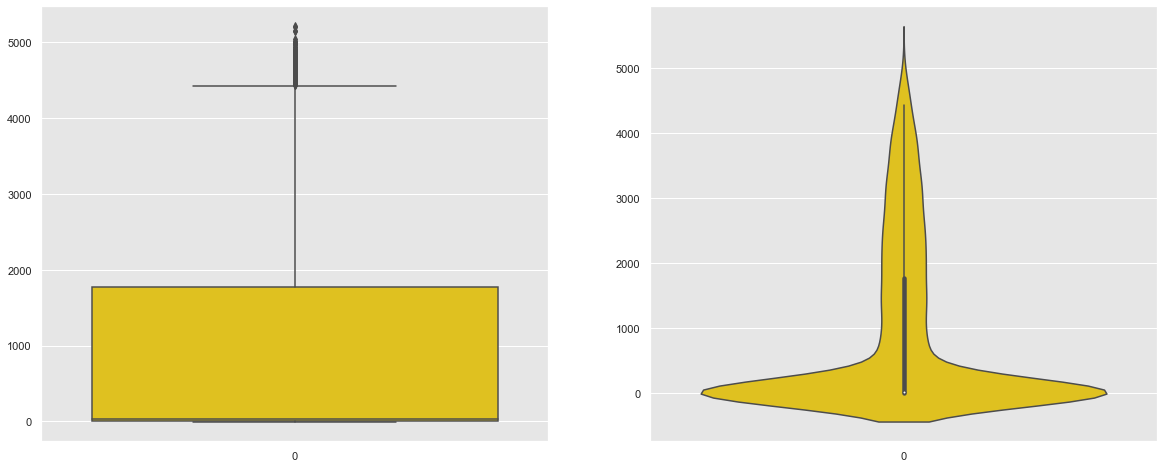

In [33]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

x = France['Solar KwH']
sns.axes_style("darkgrid")

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data = x, color = 'Gold')

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data = x, color = 'Gold',)

In [34]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

x = France['Wind KwH']
sns.axes_style("darkgrid")

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data = x, color = 'Red')

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data = x, color = 'Red',)

In [35]:
cols = ['Solar KwH', 'Atmospheric Horizontal Radiation', 'Temperature', 'Season']

scatter_df = France[cols]

sns.set(style="ticks")

df = scatter_df
sns.pairplot(df, hue = "Season")
plt.show()

In [36]:
cols = ['Wind KwH', 'Wind Velocity (10m)', 'Wind speed', 'Season']

scatter_df = France[cols]

sns.set(style="ticks")

df = scatter_df
sns.pairplot(df, hue = "Season")
plt.show()

In [37]:
plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

data = {'Month': France['Month'], 'Avg_Temp': France['Temperature'], 'Solar KwH': France['Solar KwH']}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Average Solar Generation by Month', fontsize=16)
ax1.tick_params(axis='y')

ax2 = sns.barplot(x='Month', y='Solar KwH', data = df, color = 'gold')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='Month', y='Avg_Temp', data = df, sort=False, color= 'blue')

ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Solar KwH', fontsize=16)

ax2.tick_params(axis='y')
ax2.set_ylabel('Temperature (Kelvin)', fontsize=16)
plt.show()

In [38]:
Renewable = pd.read_csv('../../Processed_Data/France_Renewable_Processed.csv')

In [39]:
Renewable.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0  2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1  2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2  2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3  2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4  2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

In [40]:
correlations = Renewable.corr(method='pearson')
correlations_price = abs(correlations['Solar KwH'])
print(correlations_price[correlations_price > 0.10]
      .sort_values(ascending=False).to_string())

Solar KwH                           1.000000
Atmospheric Horizontal Radiation    0.896812
Relative Humidity                   0.771132
Atmospheric Ground Radiation        0.759181
Total                               0.504824
Temperature                         0.493131
Wind KwH                            0.162528
Wind speed                          0.148919
Wind Velocity (10m)                 0.141872
Season                              0.121554


In [ ]:
correlations = Renewable.corr(method='pearson')
correlations_price = abs(correlations['Wind KwH'])
print(correlations_price[correlations_price > 0.10]
      .sort_values(ascending=False).to_string())

In [41]:
features = ['Atmospheric Horizontal Radiation', 'Relative Humidity', 'Atmospheric Ground Radiation', 'Temperature',
                   'Season', 'Month']

In [42]:
Renewable.isnull().any()

Date                                False
Solar KwH                           False
Wind KwH                            False
Total                               False
Temperature                         False
Relative Humidity                   False
Pressure                            False
Wind speed                          False
Wind direction                      False
Rainfall                            False
Snowfall                            False
Snow depth                          False
Wind Velocity (10m)                 False
Atmospheric Horizontal Radiation    False
Atmospheric Ground Radiation        False
Month                               False
Day                                 False
Hour                                False
Season                              False
dtype: bool

In [43]:
def plot_model_rmse_and_loss(history):
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [44]:
def plot_learning_rate_schedule(history_lr, max_loss):
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.show()

In [45]:
def naive(Data):
    
    y = Renewable['Solar KwH'].values

    y_train = y[:6132]
    y_cv = y[6132 : 7446]
    y_test = y[7446:]
    
    naive_hour_ahead = y[7446 - 1 : 8760 - 1]
    rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

    print('RMSE of hour-ahead electricity price naive forecast: {}'.format(round(rmse_naive, 3)))

naive(Renewable)

RMSE of hour-ahead electricity price naive forecast: 345.576


In [46]:
def Nueral_Network (dataset, target, start, end, timesteps):
    
    data = []
    labels = []

    if end is None:
        end = len(dataset)
        
    for i in range(start, end):
        
        indices = range(i - timesteps, i)
        data.append(dataset[indices])
        labels.append(target[i])

    return np.array(data), np.array(labels)

In [47]:
train_set = 6132
validation_set = 7446
test_set = 8760

In [48]:
dataset = Renewable[features]

In [49]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

timesteps = 3
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(dataset[:train_set])
scaled_dataset = scaler_all.transform(dataset)

Renewable = Renewable['Solar KwH'].values
scaler = MinMaxScaler(feature_range=(0, 1))

Renewable_reshaped = Renewable.reshape(-1, 1)
scaler.fit(Renewable_reshaped[:train_set])

scaled_variable = scaler.transform(Renewable_reshaped)
scaled_dataset = np.concatenate((scaled_dataset, scaled_variable), axis=1)

X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [50]:
X_train, y_train = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], 0, train_set, timesteps)
X_val, y_val = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], train_set, validation_set, timesteps)
X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [51]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

batch_size = 128
shuffle_size = 128

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

In [52]:
tf.keras.backend.clear_session()
from keras import regularizers

mlp_lr = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, kernel_regularizer=regularizers.l2(0.0009), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 1e-4, amsgrad=True)
mlp_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)

Using TensorFlow backend.


In [53]:
Learning_Rate = mlp_lr.fit(train, epochs = 50, validation_data = val, callbacks=[lr_schedule])

Epoch 1/50
48/48 [==============================] - 2s 49ms/step - loss: 0.0464 - root_mean_squared_error: 0.1855 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0232 - root_mean_squared_error: 0.1071 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1012
Epoch 3/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0157 - root_mean_squared_error: 0.0669 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1018
Epoch 4/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0141 - root_mean_squared_error: 0.0578 - val_loss: 0.0193 - val_root_mean_squared_error: 0.0922
Epoch 5/50
48/48 [==============================] - 1s 11ms/step - loss: 0.0131 - root_mean_squared_error: 0.0545 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1038
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0116 - root_mean_squared_error: 0.0466 - val_loss: 0.0185 - va

In [54]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [55]:
tf.keras.backend.clear_session()

MLP =  tf.keras.models.Sequential([
    TimeDistributed(Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  
])

optimizer = tf.keras.optimizers.Adam(lr = 0.001, amsgrad= True)
MLP.compile(loss = loss, optimizer = optimizer, metrics = metric)
MLP_Model = MLP.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
48/48 [==============================] - 2s 38ms/step - loss: 0.1092 - root_mean_squared_error: 0.1193 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0631 - root_mean_squared_error: 0.1029 - val_loss: 0.0658 - val_root_mean_squared_error: 0.1566
Epoch 3/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0415 - root_mean_squared_error: 0.0869 - val_loss: 0.0454 - val_root_mean_squared_error: 0.1274
Epoch 4/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0283 - root_mean_squared_error: 0.0631 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1269
Epoch 5/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0219 - root_mean_squared_error: 0.0560 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1213
Epoch 6/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0185 - root_mean_squared_error: 0.0576 - val_loss: 0.0248 - v

Epoch 96/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0414 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0387
Epoch 97/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0025 - root_mean_squared_error: 0.0429 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0358
Epoch 98/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0415 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0315
Epoch 99/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0024 - root_mean_squared_error: 0.0427 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0352
Epoch 100/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0024 - root_mean_squared_error: 0.0418 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0394


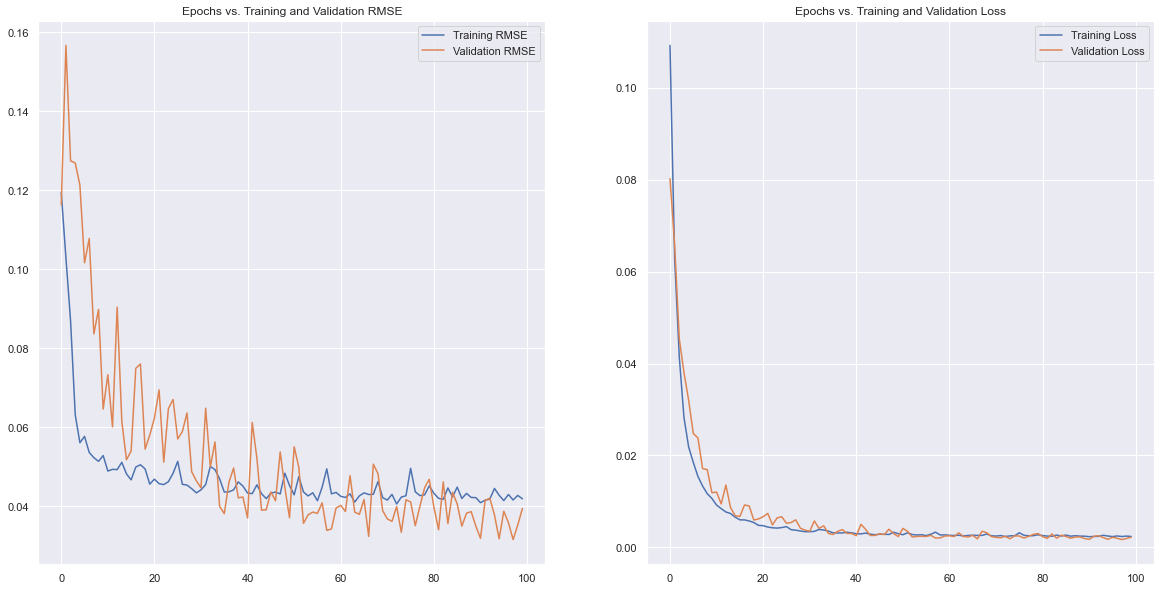

In [56]:
plot_model_rmse_and_loss(MLP_Model)

In [57]:
forecast = MLP.predict(X_test)
MLP_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, MLP_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 1231.46


In [58]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(MLP_forecast[:100], label='MLP forecast')
ax.legend(prop={'size':22})
plt.show()

In [59]:
tf.keras.backend.clear_session()

lstm_learning = tf.keras.models.Sequential([
    LSTM(50, input_shape = input_shape, return_sequences=True),
    Flatten(),
    Dense(100, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
lstm_learning.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [60]:
Learning_Rate = lstm_learning.fit(train, epochs = 50, validation_data = val, callbacks = [lr_schedule])

Epoch 1/50
48/48 [==============================] - 5s 106ms/step - loss: 0.1772 - root_mean_squared_error: 0.2652 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 1s 18ms/step - loss: 0.1386 - root_mean_squared_error: 0.1931 - val_loss: 0.1407 - val_root_mean_squared_error: 0.2040
Epoch 3/50
48/48 [==============================] - 1s 18ms/step - loss: 0.1248 - root_mean_squared_error: 0.1725 - val_loss: 0.1263 - val_root_mean_squared_error: 0.1871
Epoch 4/50
48/48 [==============================] - 1s 18ms/step - loss: 0.1118 - root_mean_squared_error: 0.1586 - val_loss: 0.1164 - val_root_mean_squared_error: 0.1822
Epoch 5/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0976 - root_mean_squared_error: 0.1418 - val_loss: 0.1096 - val_root_mean_squared_error: 0.1901
Epoch 6/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0821 - root_mean_squared_error: 0.1212 - val_loss: 0.1056 - v

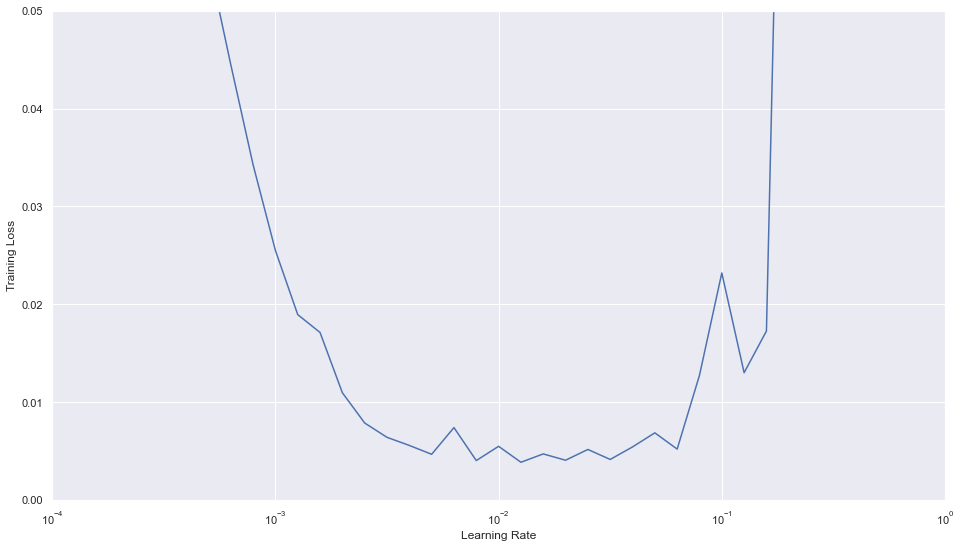

In [61]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [62]:
tf.keras.backend.clear_session()

LSTM = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, return_sequences = True),
    Flatten(),
    Dense(150, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = .001, amsgrad=True)
LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
LSTM_Model = LSTM.fit(train, epochs = 75, validation_data = val) 

Epoch 1/75
48/48 [==============================] - 5s 108ms/step - loss: 0.1428 - root_mean_squared_error: 0.1557 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/75
48/48 [==============================] - 1s 25ms/step - loss: 0.0685 - root_mean_squared_error: 0.1275 - val_loss: 0.0715 - val_root_mean_squared_error: 0.1821
Epoch 3/75
48/48 [==============================] - 1s 24ms/step - loss: 0.0377 - root_mean_squared_error: 0.0982 - val_loss: 0.0537 - val_root_mean_squared_error: 0.1747
Epoch 4/75
48/48 [==============================] - 1s 25ms/step - loss: 0.0228 - root_mean_squared_error: 0.0743 - val_loss: 0.0451 - val_root_mean_squared_error: 0.1723
Epoch 5/75
48/48 [==============================] - 1s 25ms/step - loss: 0.0153 - root_mean_squared_error: 0.0606 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1588
Epoch 6/75
48/48 [==============================] - 1s 25ms/step - loss: 0.0113 - root_mean_squared_error: 0.0567 - val_loss: 0.0303 - v

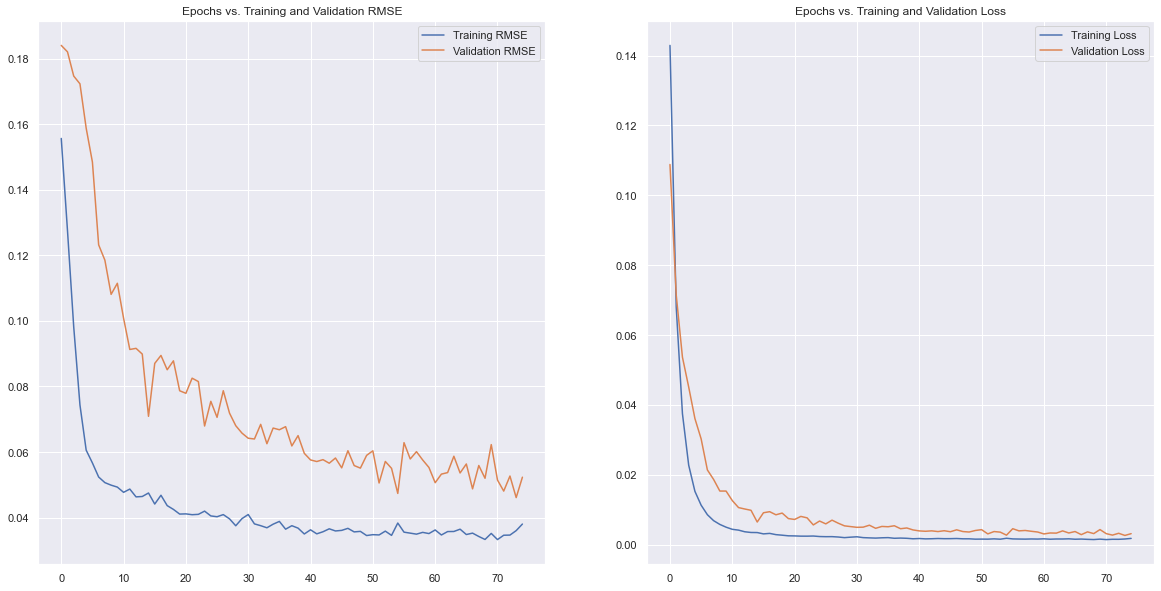

In [63]:
plot_model_rmse_and_loss(LSTM_Model)

In [64]:
forecast = LSTM.predict(X_test)
LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate LSTM forecast: 1154.577


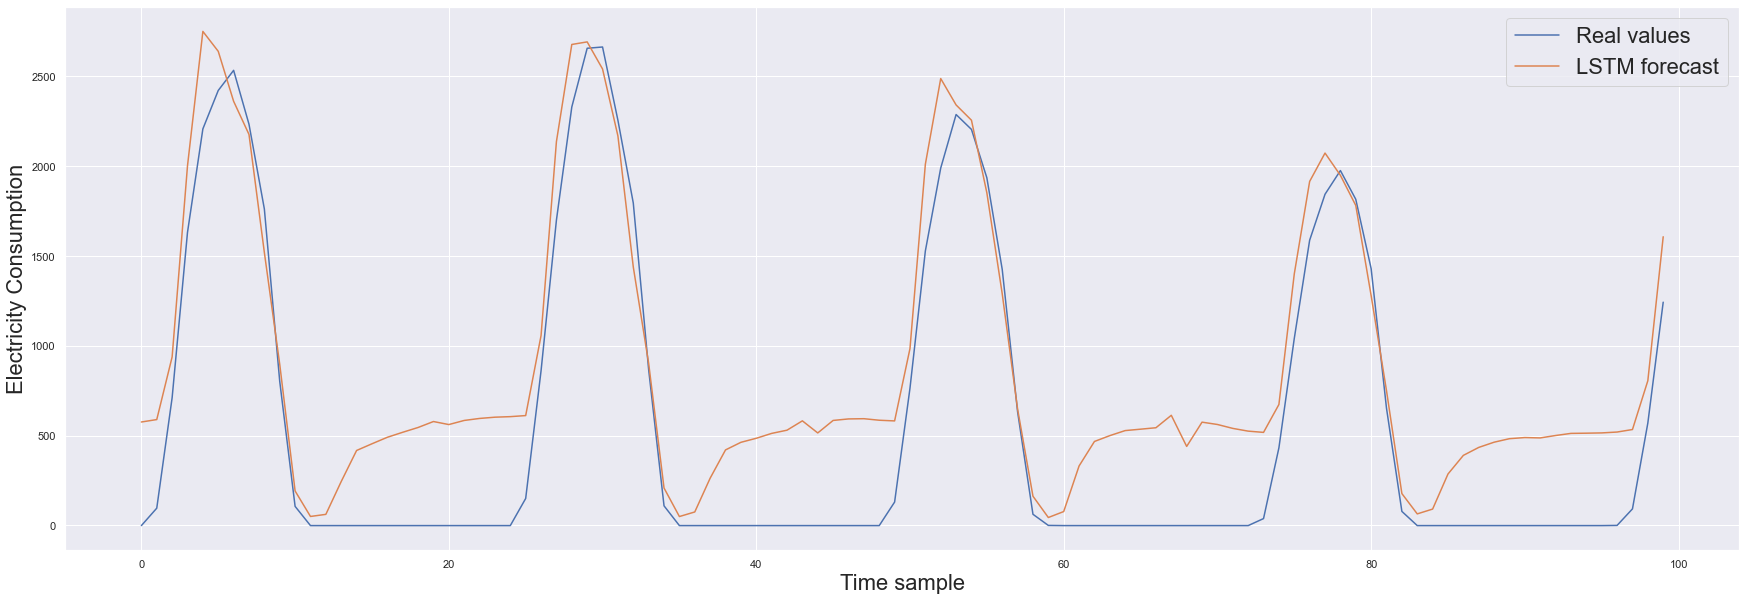

In [65]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(LSTM_forecast[:100], label='LSTM forecast')
ax.legend(prop={'size':22})
plt.show()

In [66]:
tf.keras.backend.clear_session()

cnn_lr = tf.keras.models.Sequential([ Conv1D(filters=50, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lr.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
48/48 [==============================] - 1s 28ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1885 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1876
Epoch 3/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0213 - root_mean_squared_error: 0.1468 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1550
Epoch 4/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 5/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1245
Epoch 6/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0051 - root_mean_squared_error: 0.0718 - val_loss: 0.0104 - val_roo

Epoch 49/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1412 - root_mean_squared_error: 0.3752 - val_loss: 0.0767 - val_root_mean_squared_error: 0.2794
Epoch 50/50
48/48 [==============================] - 0s 6ms/step - loss: 1.3757 - root_mean_squared_error: 1.1631 - val_loss: 0.1331 - val_root_mean_squared_error: 0.3697


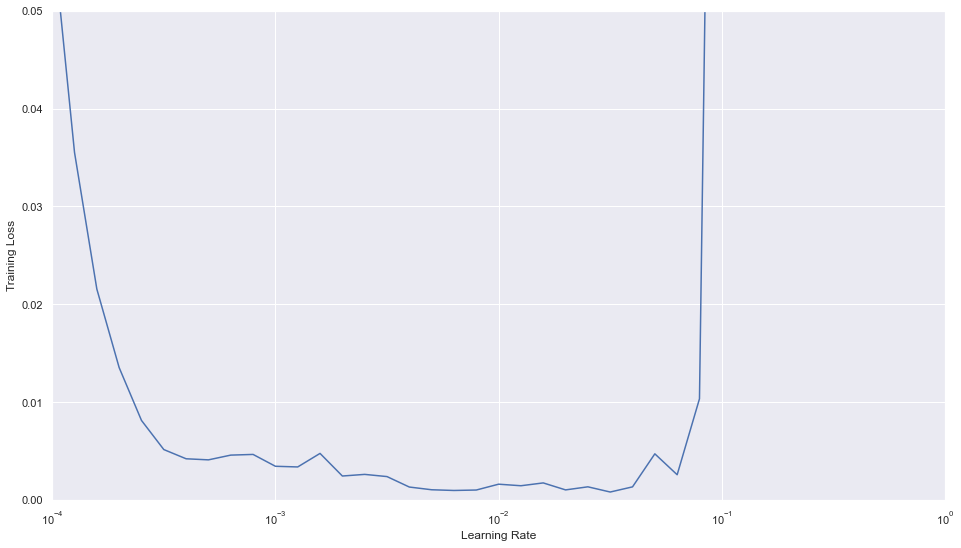

In [67]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [68]:
CNN = tf.keras.models.Sequential([Conv1D(filters = 75, kernel_size = 2, strides = 1, padding = 'causal',
                                         activation = 'relu', input_shape = input_shape),
                                  Flatten(),
                                  Dense(30, activation='relu'),
                                  Dense(1),
                                 ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_Model = CNN.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
48/48 [==============================] - 1s 27ms/step - loss: 0.0637 - root_mean_squared_error: 0.2524 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0360 - root_mean_squared_error: 0.1908 - val_loss: 0.0397 - val_root_mean_squared_error: 0.2000
Epoch 3/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0256 - root_mean_squared_error: 0.1609 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1824
Epoch 4/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0193 - root_mean_squared_error: 0.1392 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1761
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0146 - root_mean_squared_error: 0.1213 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1690
Epoch 6/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0112 - root_mean_squared_error: 0.1064 - val_loss: 0.0271 - v

Epoch 95/100
48/48 [==============================] - 0s 8ms/step - loss: 5.8251e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 96/100
48/48 [==============================] - 0s 9ms/step - loss: 5.7503e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0580
Epoch 97/100
48/48 [==============================] - 0s 6ms/step - loss: 5.7666e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 98/100
48/48 [==============================] - 0s 6ms/step - loss: 5.7487e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0581
Epoch 99/100
48/48 [==============================] - 0s 6ms/step - loss: 5.6584e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 100/100
48/48 [==============================] - 0s 6ms/step - loss: 5.5952e-04 - root_mean_squared_error: 0.0238 

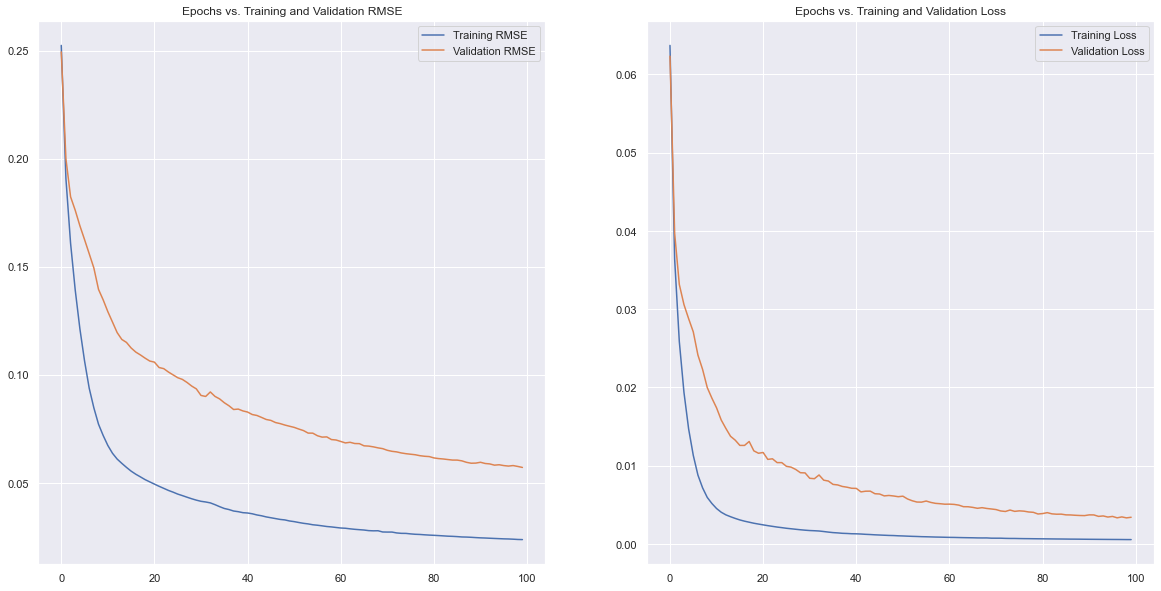

In [69]:
plot_model_rmse_and_loss(CNN_Model)

In [70]:
forecast =  CNN.predict(X_test)
CNN_forecast = scaler.inverse_transform(forecast)

rmse_CNN = sqrt(mean_squared_error(y_test, CNN_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}' .format(round(rmse_CNN, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 1252.896


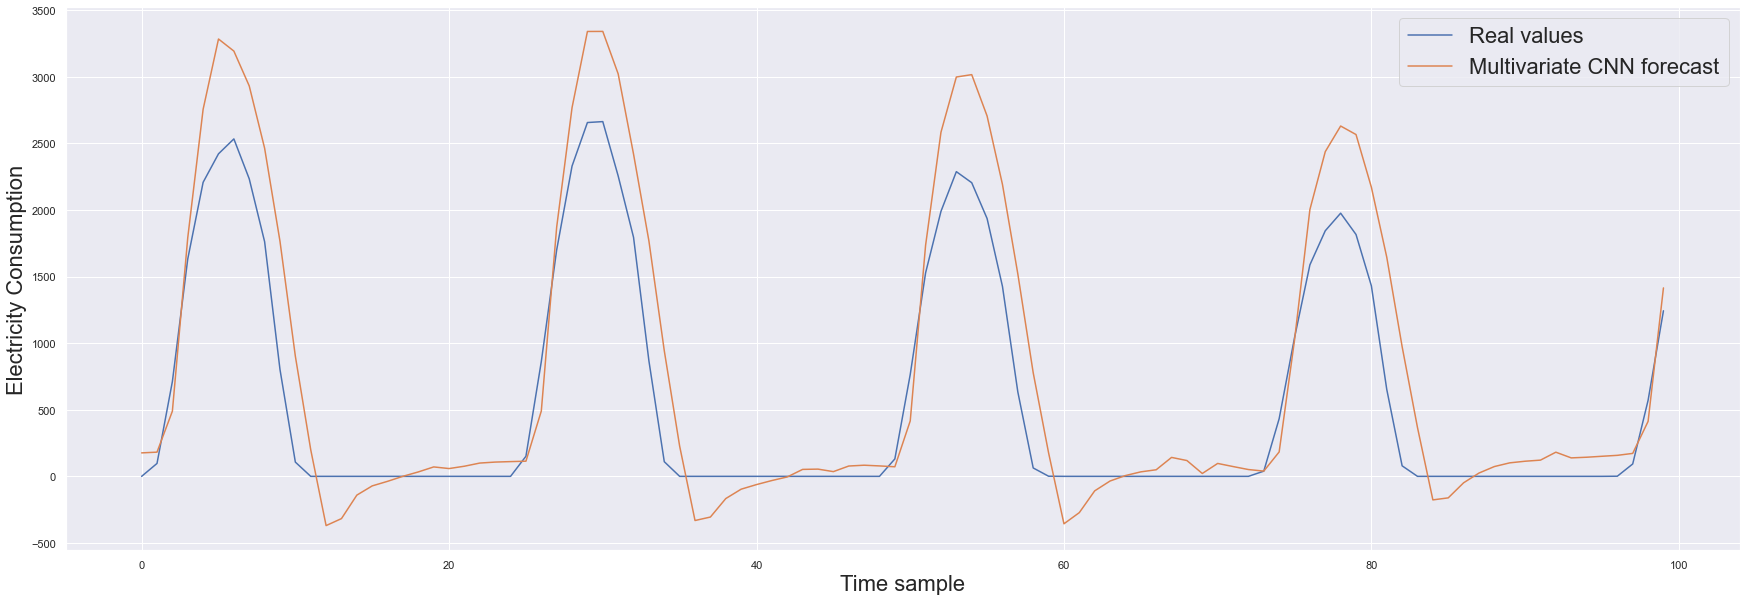

In [71]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(CNN_forecast[:100], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [74]:
tf.keras.backend.clear_session()

cnn_lstm = tf.keras.models.Sequential([ Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lstm.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
48/48 [==============================] - 6s 124ms/step - loss: 0.0585 - root_mean_squared_error: 0.2418 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 1s 25ms/step - loss: 0.0351 - root_mean_squared_error: 0.1879 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1946
Epoch 3/50
48/48 [==============================] - 1s 26ms/step - loss: 0.0235 - root_mean_squared_error: 0.1538 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1851
Epoch 4/50
48/48 [==============================] - 1s 30ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2066
Epoch 5/50
48/48 [==============================] - 1s 25ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1928
Epoch 6/50
48/48 [==============================] - 1s 25ms/step - loss: 0.0120 - root_mean_squared_error: 0.1092 - val_loss: 0.0216 - v

In [75]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [76]:
CNN_LSTM = tf.keras.models.Sequential([Conv1D(filters=100, kernel_size=2,strides=1, padding='causal',
                                              activation='relu', input_shape = input_shape),
                                       LSTM(50, return_sequences=True),
                                       Flatten(),
                                       Dense(30, activation='relu'),
                                       Dense(1) 
                                      ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN_LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_LSTM_Model = CNN_LSTM.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
48/48 [==============================] - 5s 107ms/step - loss: 0.0520 - root_mean_squared_error: 0.2280 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 1s 21ms/step - loss: 0.0345 - root_mean_squared_error: 0.1866 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2037
Epoch 3/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0277 - root_mean_squared_error: 0.1672 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1891
Epoch 4/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0220 - root_mean_squared_error: 0.1487 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1810
Epoch 5/100
48/48 [==============================] - 1s 20ms/step - loss: 0.0161 - root_mean_squared_error: 0.1273 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1819
Epoch 6/100
48/48 [==============================] - 1s 20ms/step - loss: 0.0107 - root_mean_squared_error: 0.1037 - val_loss: 0.04

48/48 [==============================] - 1s 19ms/step - loss: 4.9726e-04 - root_mean_squared_error: 0.0224 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0571
Epoch 95/100
48/48 [==============================] - 1s 18ms/step - loss: 4.9893e-04 - root_mean_squared_error: 0.0224 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0579
Epoch 96/100
48/48 [==============================] - 1s 19ms/step - loss: 4.8982e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0579
Epoch 97/100
48/48 [==============================] - 1s 19ms/step - loss: 4.8833e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0582
Epoch 98/100
48/48 [==============================] - 1s 19ms/step - loss: 4.8165e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0570
Epoch 99/100
48/48 [==============================] - 1s 19ms/step - loss: 4.8033e-04 - root_mean_squared_error: 0.0220 - val_lo

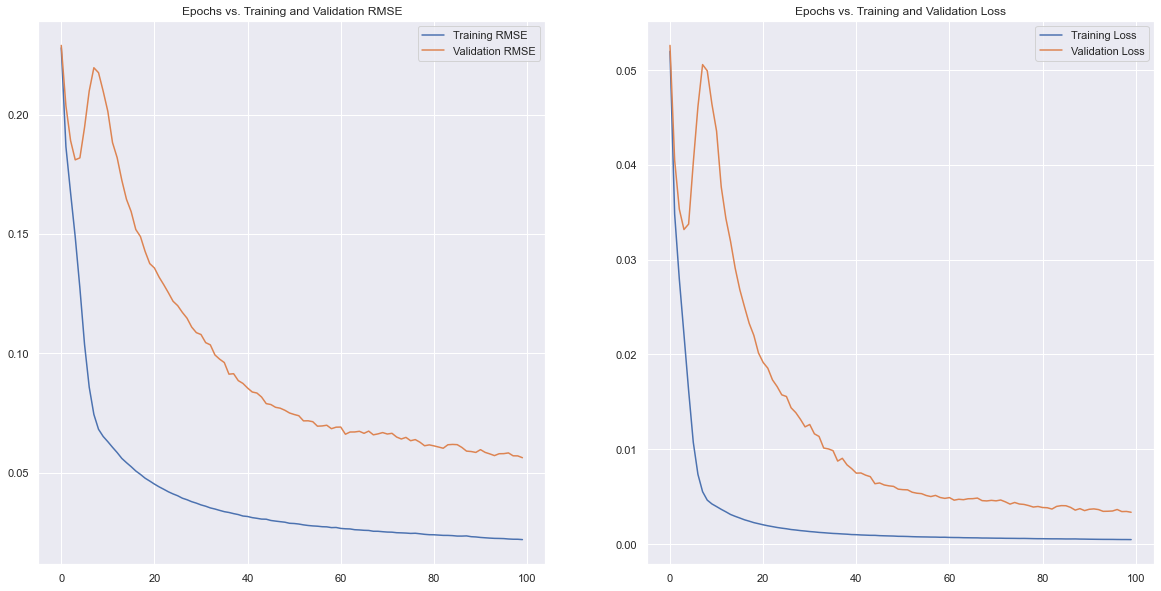

In [77]:
plot_model_rmse_and_loss(CNN_LSTM_Model)

In [78]:
forecast =  CNN_LSTM.predict(X_test)
CNN_LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, CNN_LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: 1321.41


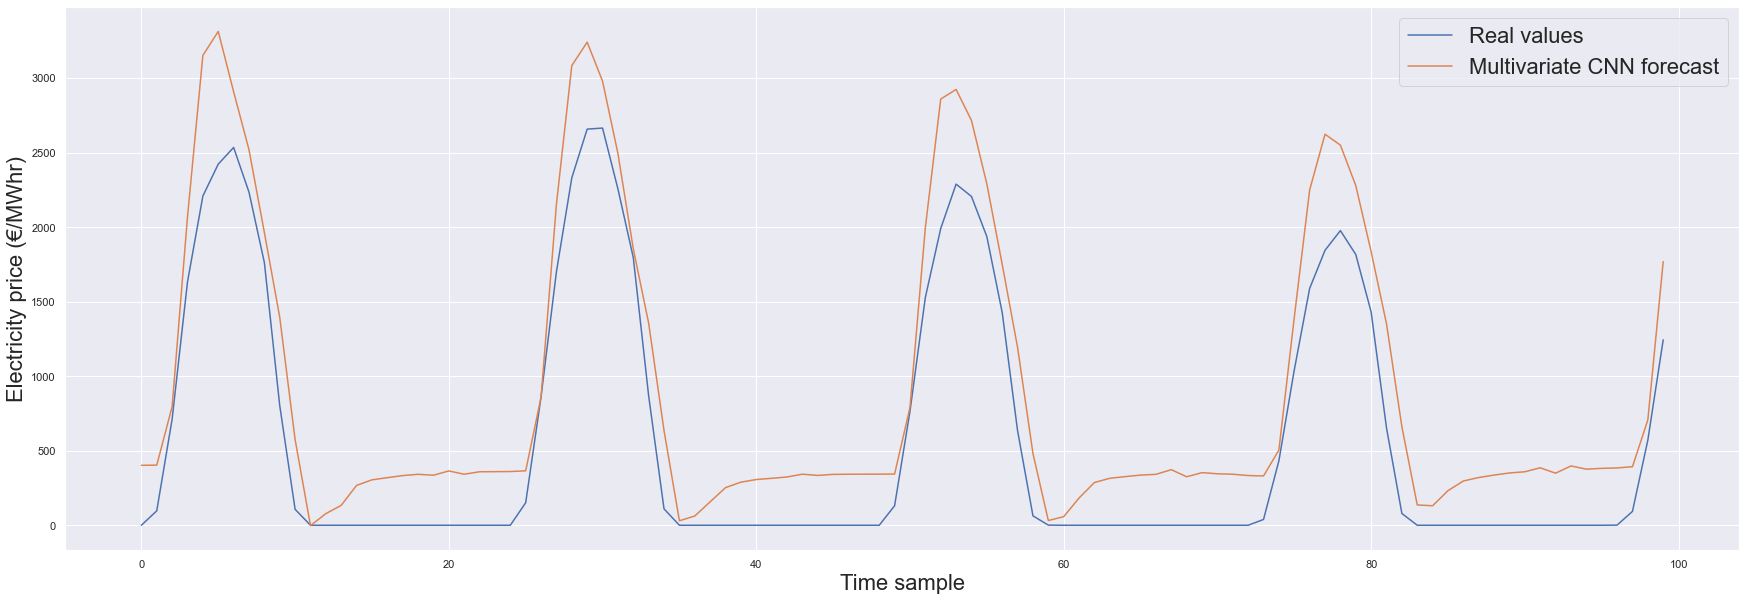

In [79]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity price (€/MWhr)', fontsize=22)
ax.plot(y_test_inv[:100], label='Real values')
ax.plot(CNN_LSTM_forecast[:100], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [81]:
Renewable_wind = pd.read_csv('../../Processed_Data/France_Renewable_Processed.csv')

In [82]:
Renewable_wind.head()

Date  Solar KwH  Wind KwH   Total  Temperature  \
0  2016-01-01 00:00:00       -1.0    2082.0  2081.0       279.84   
1  2016-01-01 01:00:00       -1.0    1690.0  1689.0       282.79   
2  2016-01-01 02:00:00       -1.0    1414.0  1413.0       278.20   
3  2016-01-01 03:00:00       -1.0    1200.0  1199.0       278.11   
4  2016-01-01 04:00:00       -1.0    1000.0   999.0       278.08   

   Relative Humidity  Pressure  Wind speed  Wind direction  Rainfall  \
0              92.48    982.65        5.70          155.61      0.45   
1              83.61   1005.81        2.13           89.96      0.01   
2              96.71    994.89        2.31          170.60      0.01   
3              96.42    994.89        2.29          171.33      0.01   
4              95.59    994.74        2.34          168.74      0.01   

   Snowfall  Snow depth  Wind Velocity (10m)  \
0       0.0         0.0                 2.86   
1       0.0         0.0                 2.68   
2       0.0         0.0                 2.51   
3       0.0         0.0                 2.45   
4       0.0         0.0                 2.35   

   Atmospheric Horizontal Radiation  Atmospheric Ground Radiation  Month  Day  \
0                               0.0                           0.0    1.0  4.0   
1                               0.0                           0.0    1.0  4.0   
2                               0.0                           0.0    1.0  4.0   
3                               0.0                           0.0    1.0  4.0   
4                               0.0                           0.0    1.0  4.0   

   Hour  Season  
0   0.0     1.0  
1   1.0     1.0  
2   2.0     1.0  
3   3.0     1.0  
4   4.0     1.0

In [83]:
correlations = Renewable_wind.corr(method='pearson')
correlations_price = abs(correlations['Wind KwH'])
print(correlations_price[correlations_price > 0.10]
      .sort_values(ascending=False).to_string())

Wind KwH                            1.000000
Wind Velocity (10m)                 0.880759
Wind speed                          0.809981
Total                               0.769697
Temperature                         0.315001
Season                              0.291368
Month                               0.291294
Pressure                            0.285646
Rainfall                            0.250157
Atmospheric Horizontal Radiation    0.199574
Snowfall                            0.190575
Relative Humidity                   0.180323
Solar KwH                           0.162528


In [84]:
features = ['Wind speed', 'Wind direction', 'Pressure', 'Wind Velocity (10m)', 'Season', 'Month', 'Rainfall']

In [88]:
def naive(Data):
    
    y = Renewable_wind['Wind KwH'].values

    y_train = y[:6000]
    y_cv = y[6000 : 7200]
    y_test = y[7200:]
    
    naive_hour_ahead = y[7200 - 1 : 8760 - 1]
    rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

    print('RMSE of hour-ahead electricity price naive forecast: {}'.format(round(rmse_naive, 3)))

naive(Renewable)

RMSE of hour-ahead electricity price naive forecast: 214.897


In [89]:
train_set = 6000
validation_set = 7200
test_set = 8760

In [90]:
dataset = Renewable_wind[features]

In [92]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

timesteps = 3
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(dataset[:train_set])
scaled_dataset = scaler_all.transform(dataset)

Renewable = Renewable_wind['Wind KwH'].values
scaler = MinMaxScaler(feature_range=(0, 1))

Renewable_reshaped = Renewable.reshape(-1, 1)
scaler.fit(Renewable_reshaped[:train_set])

scaled_variable = scaler.transform(Renewable_reshaped)
scaled_dataset = np.concatenate((scaled_dataset, scaled_variable), axis=1)

X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [93]:
X_train, y_train = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], 0, train_set, timesteps)
X_val, y_val = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], train_set, validation_set, timesteps)
X_test, y_test = Nueral_Network(scaled_dataset, scaled_dataset[:, -1], validation_set, test_set, timesteps)

In [94]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

batch_size = 128
shuffle_size = 128

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(shuffle_size).batch(shuffle_size).prefetch(1)

In [95]:
tf.keras.backend.clear_session()
from keras import regularizers

mlp_lr = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, kernel_regularizer=regularizers.l2(0.0009), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 1e-4, amsgrad=True)
mlp_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [96]:
Learning_Rate = mlp_lr.fit(train, epochs = 50, validation_data = val, callbacks=[lr_schedule])

Epoch 1/50
47/47 [==============================] - 2s 50ms/step - loss: 0.0958 - root_mean_squared_error: 0.2867 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0484 - root_mean_squared_error: 0.1856 - val_loss: 0.0209 - val_root_mean_squared_error: 0.0882
Epoch 3/50
47/47 [==============================] - 1s 17ms/step - loss: 0.0225 - root_mean_squared_error: 0.0976 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0598
Epoch 4/50
47/47 [==============================] - 1s 22ms/step - loss: 0.0164 - root_mean_squared_error: 0.0644 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0545
Epoch 5/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0146 - root_mean_squared_error: 0.0552 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0505
Epoch 6/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0137 - root_mean_squared_error: 0.0543 - val_loss: 0.0121 - va

In [97]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [98]:
tf.keras.backend.clear_session()

MLP =  tf.keras.models.Sequential([
    TimeDistributed(Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'), input_shape = input_shape),
    TimeDistributed(Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu')),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  
])

optimizer = tf.keras.optimizers.Adam(lr = 0.001, amsgrad= True)
MLP.compile(loss = loss, optimizer = optimizer, metrics = metric)
MLP_Model = MLP.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
47/47 [==============================] - 2s 46ms/step - loss: 0.1253 - root_mean_squared_error: 0.1433 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0692 - root_mean_squared_error: 0.0696 - val_loss: 0.0526 - val_root_mean_squared_error: 0.0413
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0470 - root_mean_squared_error: 0.0617 - val_loss: 0.0380 - val_root_mean_squared_error: 0.0440
Epoch 4/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0352 - root_mean_squared_error: 0.0584 - val_loss: 0.0288 - val_root_mean_squared_error: 0.0357
Epoch 5/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0279 - root_mean_squared_error: 0.0555 - val_loss: 0.0235 - val_root_mean_squared_error: 0.0393
Epoch 6/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0231 - root_mean_squared_error: 0.0549 - val_loss: 0.0194 -

Epoch 96/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0397 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0231
Epoch 97/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0021 - root_mean_squared_error: 0.0380 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0232
Epoch 98/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0021 - root_mean_squared_error: 0.0382 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0238
Epoch 99/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0361 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0258
Epoch 100/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0021 - root_mean_squared_error: 0.0385 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0243


In [99]:
plot_model_rmse_and_loss(MLP_Model)

In [100]:
forecast = MLP.predict(X_test)
MLP_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, MLP_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate MLP forecast: 3019.859


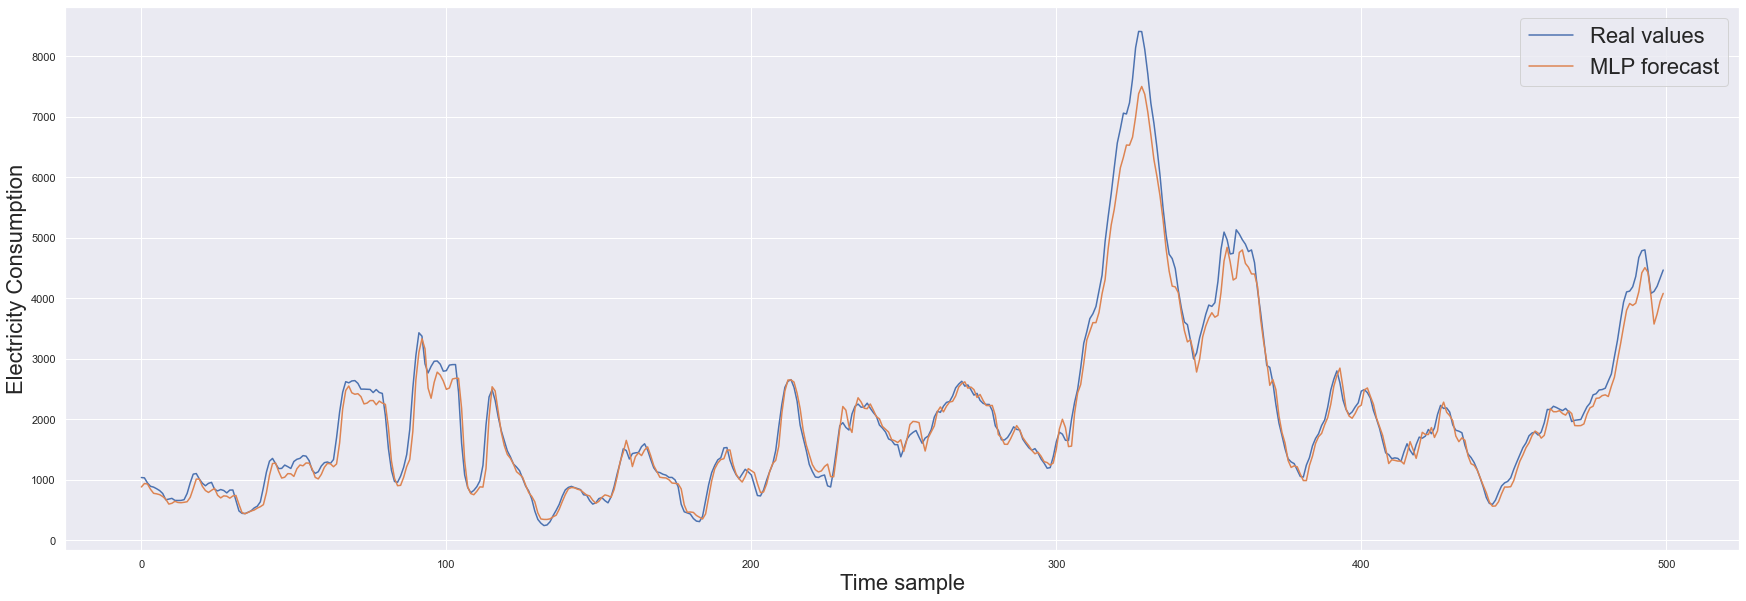

In [101]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(MLP_forecast[:500], label='MLP forecast')
ax.legend(prop={'size':22})
plt.show()

In [102]:
tf.keras.backend.clear_session()

lstm_learning = tf.keras.models.Sequential([
    LSTM(50, input_shape = input_shape, return_sequences=True),
    Flatten(),
    Dense(100, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
lstm_learning.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [103]:
Learning_Rate = lstm_learning.fit(train, epochs = 50, validation_data = val, callbacks = [lr_schedule])

Epoch 1/50
47/47 [==============================] - 5s 102ms/step - loss: 0.1907 - root_mean_squared_error: 0.2934 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
47/47 [==============================] - 1s 19ms/step - loss: 0.1434 - root_mean_squared_error: 0.2058 - val_loss: 0.1066 - val_root_mean_squared_error: 0.0955
Epoch 3/50
47/47 [==============================] - 1s 19ms/step - loss: 0.1205 - root_mean_squared_error: 0.1592 - val_loss: 0.1040 - val_root_mean_squared_error: 0.1120
Epoch 4/50
47/47 [==============================] - 1s 21ms/step - loss: 0.1037 - root_mean_squared_error: 0.1230 - val_loss: 0.0943 - val_root_mean_squared_error: 0.0996
Epoch 5/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0912 - root_mean_squared_error: 0.1006 - val_loss: 0.0818 - val_root_mean_squared_error: 0.0716
Epoch 6/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0809 - root_mean_squared_error: 0.0909 - val_loss: 0.0723 - v

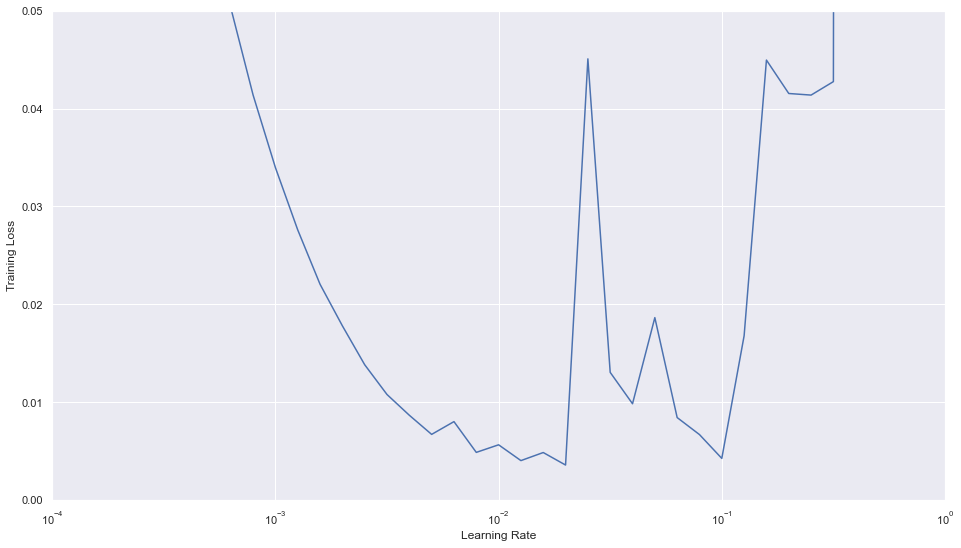

In [104]:
plot_learning_rate_schedule(Learning_Rate, 0.05)

In [105]:
tf.keras.backend.clear_session()

LSTM = tf.keras.models.Sequential([
    LSTM(100, input_shape = input_shape, return_sequences = True),
    Flatten(),
    Dense(150, kernel_regularizer=regularizers.l2(0.0009), activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = .001, amsgrad=True)
LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
LSTM_Model = LSTM.fit(train, epochs = 75, validation_data = val)  

Epoch 1/75
47/47 [==============================] - 6s 121ms/step - loss: 0.1660 - root_mean_squared_error: 0.1706 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/75
47/47 [==============================] - 1s 25ms/step - loss: 0.0820 - root_mean_squared_error: 0.0747 - val_loss: 0.0598 - val_root_mean_squared_error: 0.0550
Epoch 3/75
47/47 [==============================] - 1s 26ms/step - loss: 0.0502 - root_mean_squared_error: 0.0646 - val_loss: 0.0393 - val_root_mean_squared_error: 0.0563
Epoch 4/75
47/47 [==============================] - 1s 26ms/step - loss: 0.0339 - root_mean_squared_error: 0.0605 - val_loss: 0.0273 - val_root_mean_squared_error: 0.0537
Epoch 5/75
47/47 [==============================] - 1s 26ms/step - loss: 0.0243 - root_mean_squared_error: 0.0585 - val_loss: 0.0199 - val_root_mean_squared_error: 0.0510
Epoch 6/75
47/47 [==============================] - 1s 26ms/step - loss: 0.0184 - root_mean_squared_error: 0.0591 - val_loss: 0.0155 - v

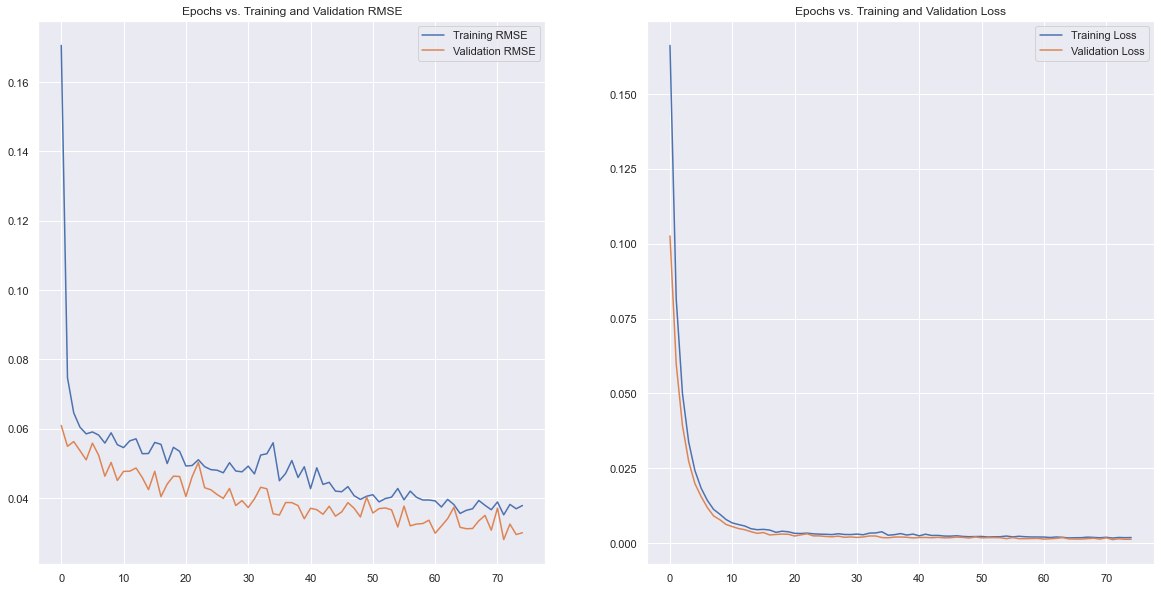

In [106]:
plot_model_rmse_and_loss(LSTM_Model)

In [107]:
forecast = LSTM.predict(X_test)
LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate LSTM forecast: {}' .format(round(rmse_lstm, 3)))

RMSE of hour-ahead electricity price multivariate LSTM forecast: 3013.617


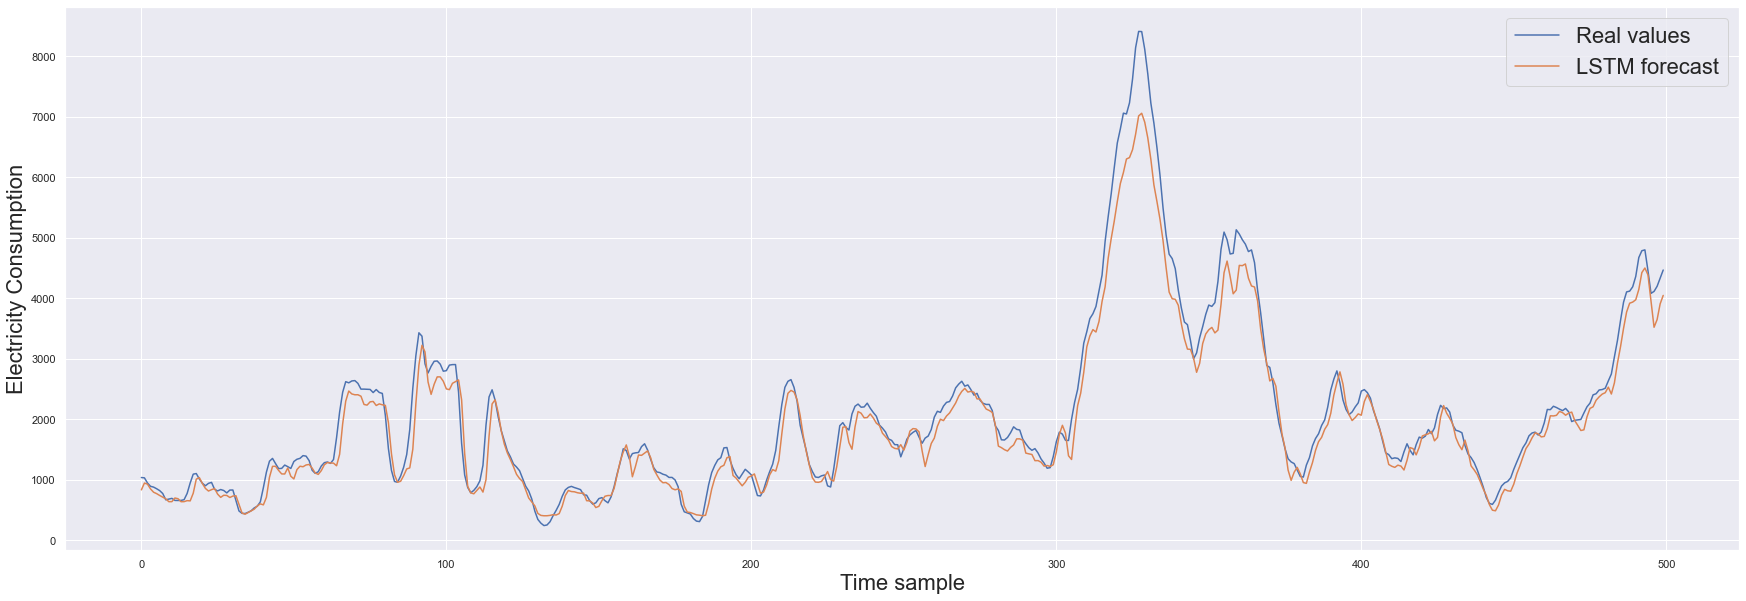

In [108]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(LSTM_forecast[:500], label='LSTM forecast')
ax.legend(prop={'size':22})
plt.show()

In [109]:
tf.keras.backend.clear_session()

cnn_lr = tf.keras.models.Sequential([ Conv1D(filters=50, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lr.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lr.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
47/47 [==============================] - 2s 36ms/step - loss: 0.2043 - root_mean_squared_error: 0.4526 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0857 - root_mean_squared_error: 0.2910 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1565
Epoch 3/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0398 - root_mean_squared_error: 0.1978 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1034
Epoch 4/50
47/47 [==============================] - 55s 1s/step - loss: 0.0154 - root_mean_squared_error: 0.1233 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0966
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0091 - root_mean_squared_error: 0.0949 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 6/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0047 - val_ro

Epoch 49/50
47/47 [==============================] - 0s 6ms/step - loss: 0.1051 - root_mean_squared_error: 0.3216 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1404
Epoch 50/50
47/47 [==============================] - 0s 6ms/step - loss: 0.1417 - root_mean_squared_error: 0.3734 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1453


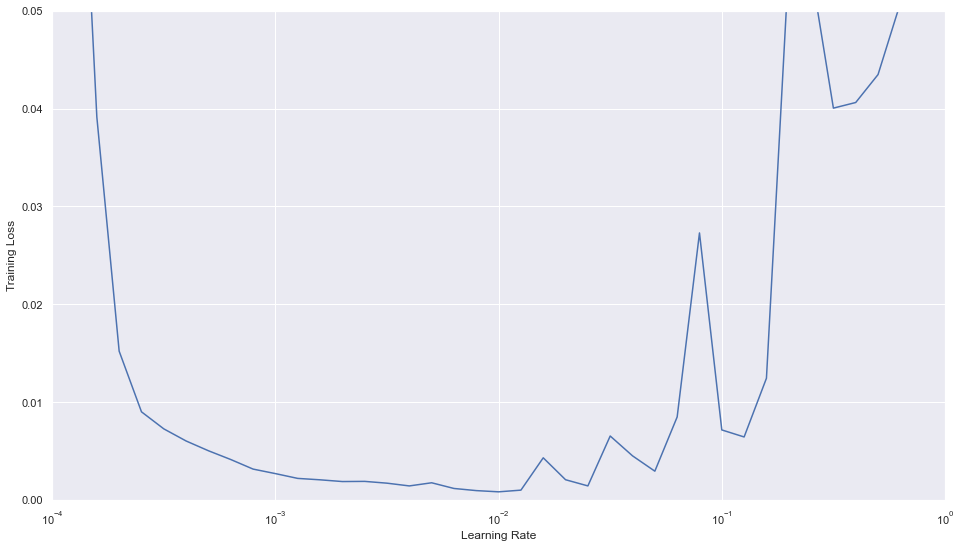

In [110]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [111]:
CNN = tf.keras.models.Sequential([Conv1D(filters = 75, kernel_size = 2, strides = 1, padding = 'causal',
                                         activation = 'relu', input_shape = input_shape),
                                  Flatten(),
                                  Dense(30, activation='relu'),
                                  Dense(1),
                                 ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_Model = CNN.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
47/47 [==============================] - 1s 28ms/step - loss: 0.0665 - root_mean_squared_error: 0.2582 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0483 - root_mean_squared_error: 0.2181 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1737
Epoch 3/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0334 - root_mean_squared_error: 0.1813 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1439
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0203 - root_mean_squared_error: 0.1412 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1013
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0121 - root_mean_squared_error: 0.1092 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0668
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0075 - root_mean_squared_error: 0.0861 - val_loss: 0.0035 - 

47/47 [==============================] - 0s 7ms/step - loss: 6.6636e-04 - root_mean_squared_error: 0.0257 - val_loss: 7.0142e-04 - val_root_mean_squared_error: 0.0269
Epoch 95/100
47/47 [==============================] - 0s 6ms/step - loss: 6.5134e-04 - root_mean_squared_error: 0.0254 - val_loss: 7.0831e-04 - val_root_mean_squared_error: 0.0269
Epoch 96/100
47/47 [==============================] - 0s 6ms/step - loss: 6.4452e-04 - root_mean_squared_error: 0.0253 - val_loss: 6.8384e-04 - val_root_mean_squared_error: 0.0267
Epoch 97/100
47/47 [==============================] - 0s 6ms/step - loss: 6.3822e-04 - root_mean_squared_error: 0.0252 - val_loss: 6.9856e-04 - val_root_mean_squared_error: 0.0268
Epoch 98/100
47/47 [==============================] - 0s 6ms/step - loss: 6.3360e-04 - root_mean_squared_error: 0.0251 - val_loss: 6.9900e-04 - val_root_mean_squared_error: 0.0267
Epoch 99/100
47/47 [==============================] - 0s 6ms/step - loss: 6.2358e-04 - root_mean_squared_error: 0

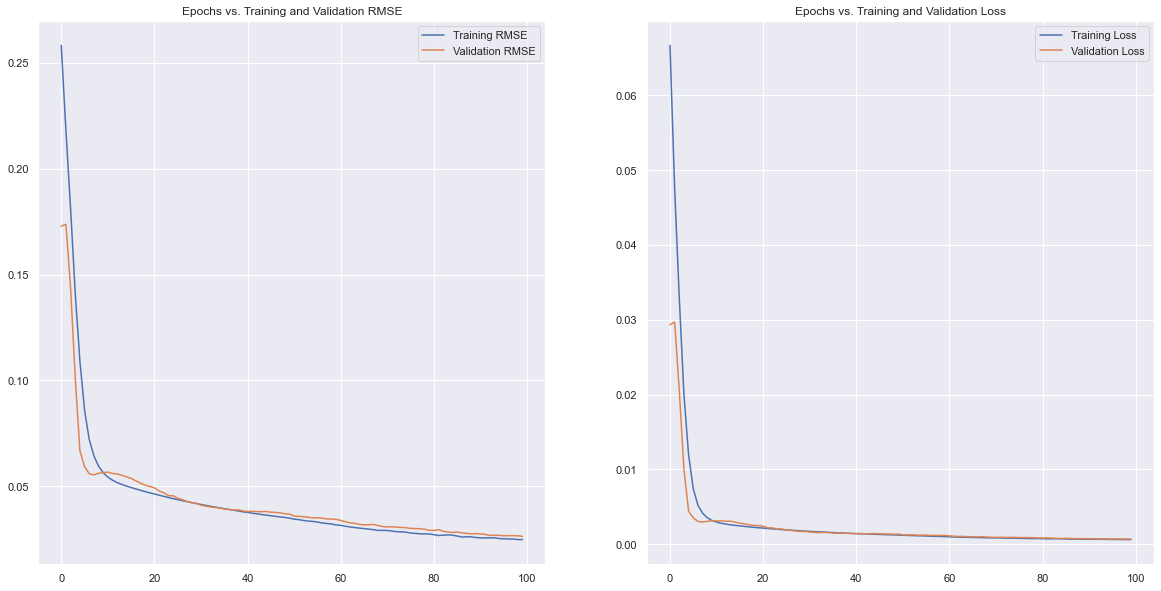

In [112]:
plot_model_rmse_and_loss(CNN_Model)

In [113]:
forecast =  CNN.predict(X_test)
CNN_forecast = scaler.inverse_transform(forecast)

rmse_CNN = sqrt(mean_squared_error(y_test, CNN_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}' .format(round(rmse_CNN, 3)))

RMSE of hour-ahead electricity price multivariate CNN forecast: 3407.216


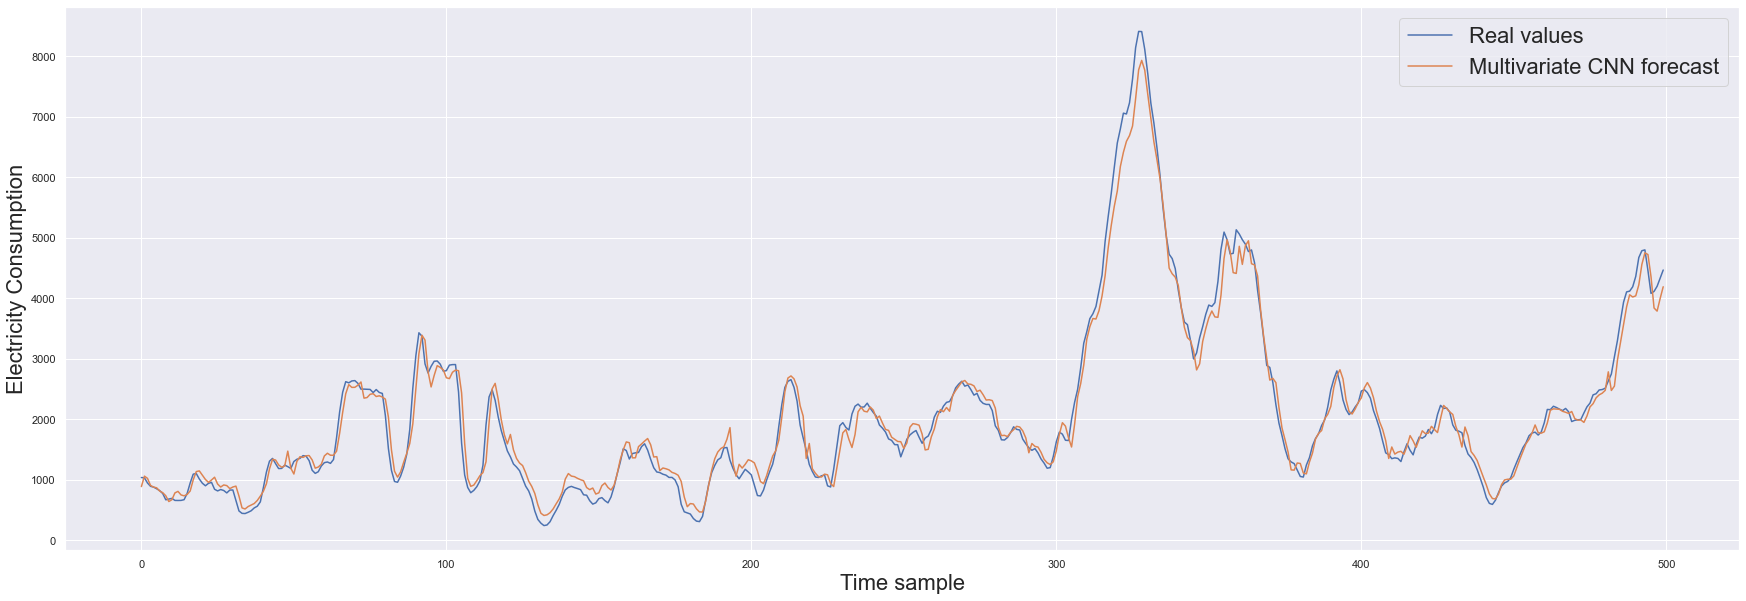

In [114]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity Consumption', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(CNN_forecast[:500], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()

In [117]:
tf.keras.backend.clear_session()

cnn_lstm = tf.keras.models.Sequential([ Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
cnn_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
learning_rate = cnn_lstm.fit(train, epochs=50, validation_data=val, callbacks=[lr_schedule])

Epoch 1/50
47/47 [==============================] - 7s 139ms/step - loss: 0.0808 - root_mean_squared_error: 0.2846 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
47/47 [==============================] - 1s 26ms/step - loss: 0.0482 - root_mean_squared_error: 0.2180 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1109
Epoch 3/50
47/47 [==============================] - 1s 26ms/step - loss: 0.0274 - root_mean_squared_error: 0.1644 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1261
Epoch 4/50
47/47 [==============================] - 1s 26ms/step - loss: 0.0126 - root_mean_squared_error: 0.1113 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 5/50
47/47 [==============================] - 1s 26ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0723
Epoch 6/50
47/47 [==============================] - 1s 26ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0026 - v

In [118]:
plot_learning_rate_schedule(learning_rate, 0.05)

In [ ]:
CNN_LSTM = tf.keras.models.Sequential([Conv1D(filters=100, kernel_size=2,strides=1, padding='causal',
                                              activation='relu', input_shape = input_shape),
                                       LSTM(50, return_sequences=True),
                                       Flatten(),
                                       Dense(30, activation='relu'),
                                       Dense(1) 
                                      ])

optimizer = tf.keras.optimizers.Adam(lr = .0001, amsgrad=True)
CNN_LSTM.compile(loss = loss, optimizer = optimizer, metrics = metric)
CNN_LSTM_Model = CNN_LSTM.fit(train, epochs = 100, validation_data = val) 

Epoch 1/100
47/47 [==============================] - 5s 102ms/step - loss: 0.1010 - root_mean_squared_error: 0.3181 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0606 - root_mean_squared_error: 0.2445 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1175
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0374 - root_mean_squared_error: 0.1921 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0979
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0222 - root_mean_squared_error: 0.1480 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1044
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0129 - root_mean_squared_error: 0.1131 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1071
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0092 - root_mean_squared_error: 0.0954 - val_loss: 0.00

30/47 [==================>...........] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0353

In [ ]:
plot_model_rmse_and_loss(CNN_LSTM_Model)

In [ ]:
forecast =  CNN_LSTM.predict(X_test)
CNN_LSTM_forecast = scaler.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test, CNN_LSTM_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN_LSTM forecast: {}' .format(round(rmse_lstm, 3)))

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Time sample', fontsize=22)
ax.set_ylabel('Electricity price (€/MWhr)', fontsize=22)
ax.plot(y_test_inv[:500], label='Real values')
ax.plot(CNN_LSTM_forecast[:500], label='Multivariate CNN forecast')
ax.legend(prop={'size':22})
plt.show()